Loading file: Aug '25/Aug 07 Exp/01 Aug/5S/nse_nifty2580724600ce_min.csv
Strike: 4600, Option Type: CE
Data loaded successfully. Shape: (4500, 27)

Summary Statistics:
Strike Price                                                  4600
Option Type                                                     CE
Total Records                                                 4500
Date Range              2025-08-01 09:15:00 to 2025-08-01 15:29:55
Current Price                                                129.1
Open Price                                                   250.0
Total Price Change                                          -120.9
Total Price Change %                                        -48.36
Highest Price                                                269.0
Lowest Price                                                 124.5
Average Price                                           196.747711
Total Volume                                              79821225
Average Volume              

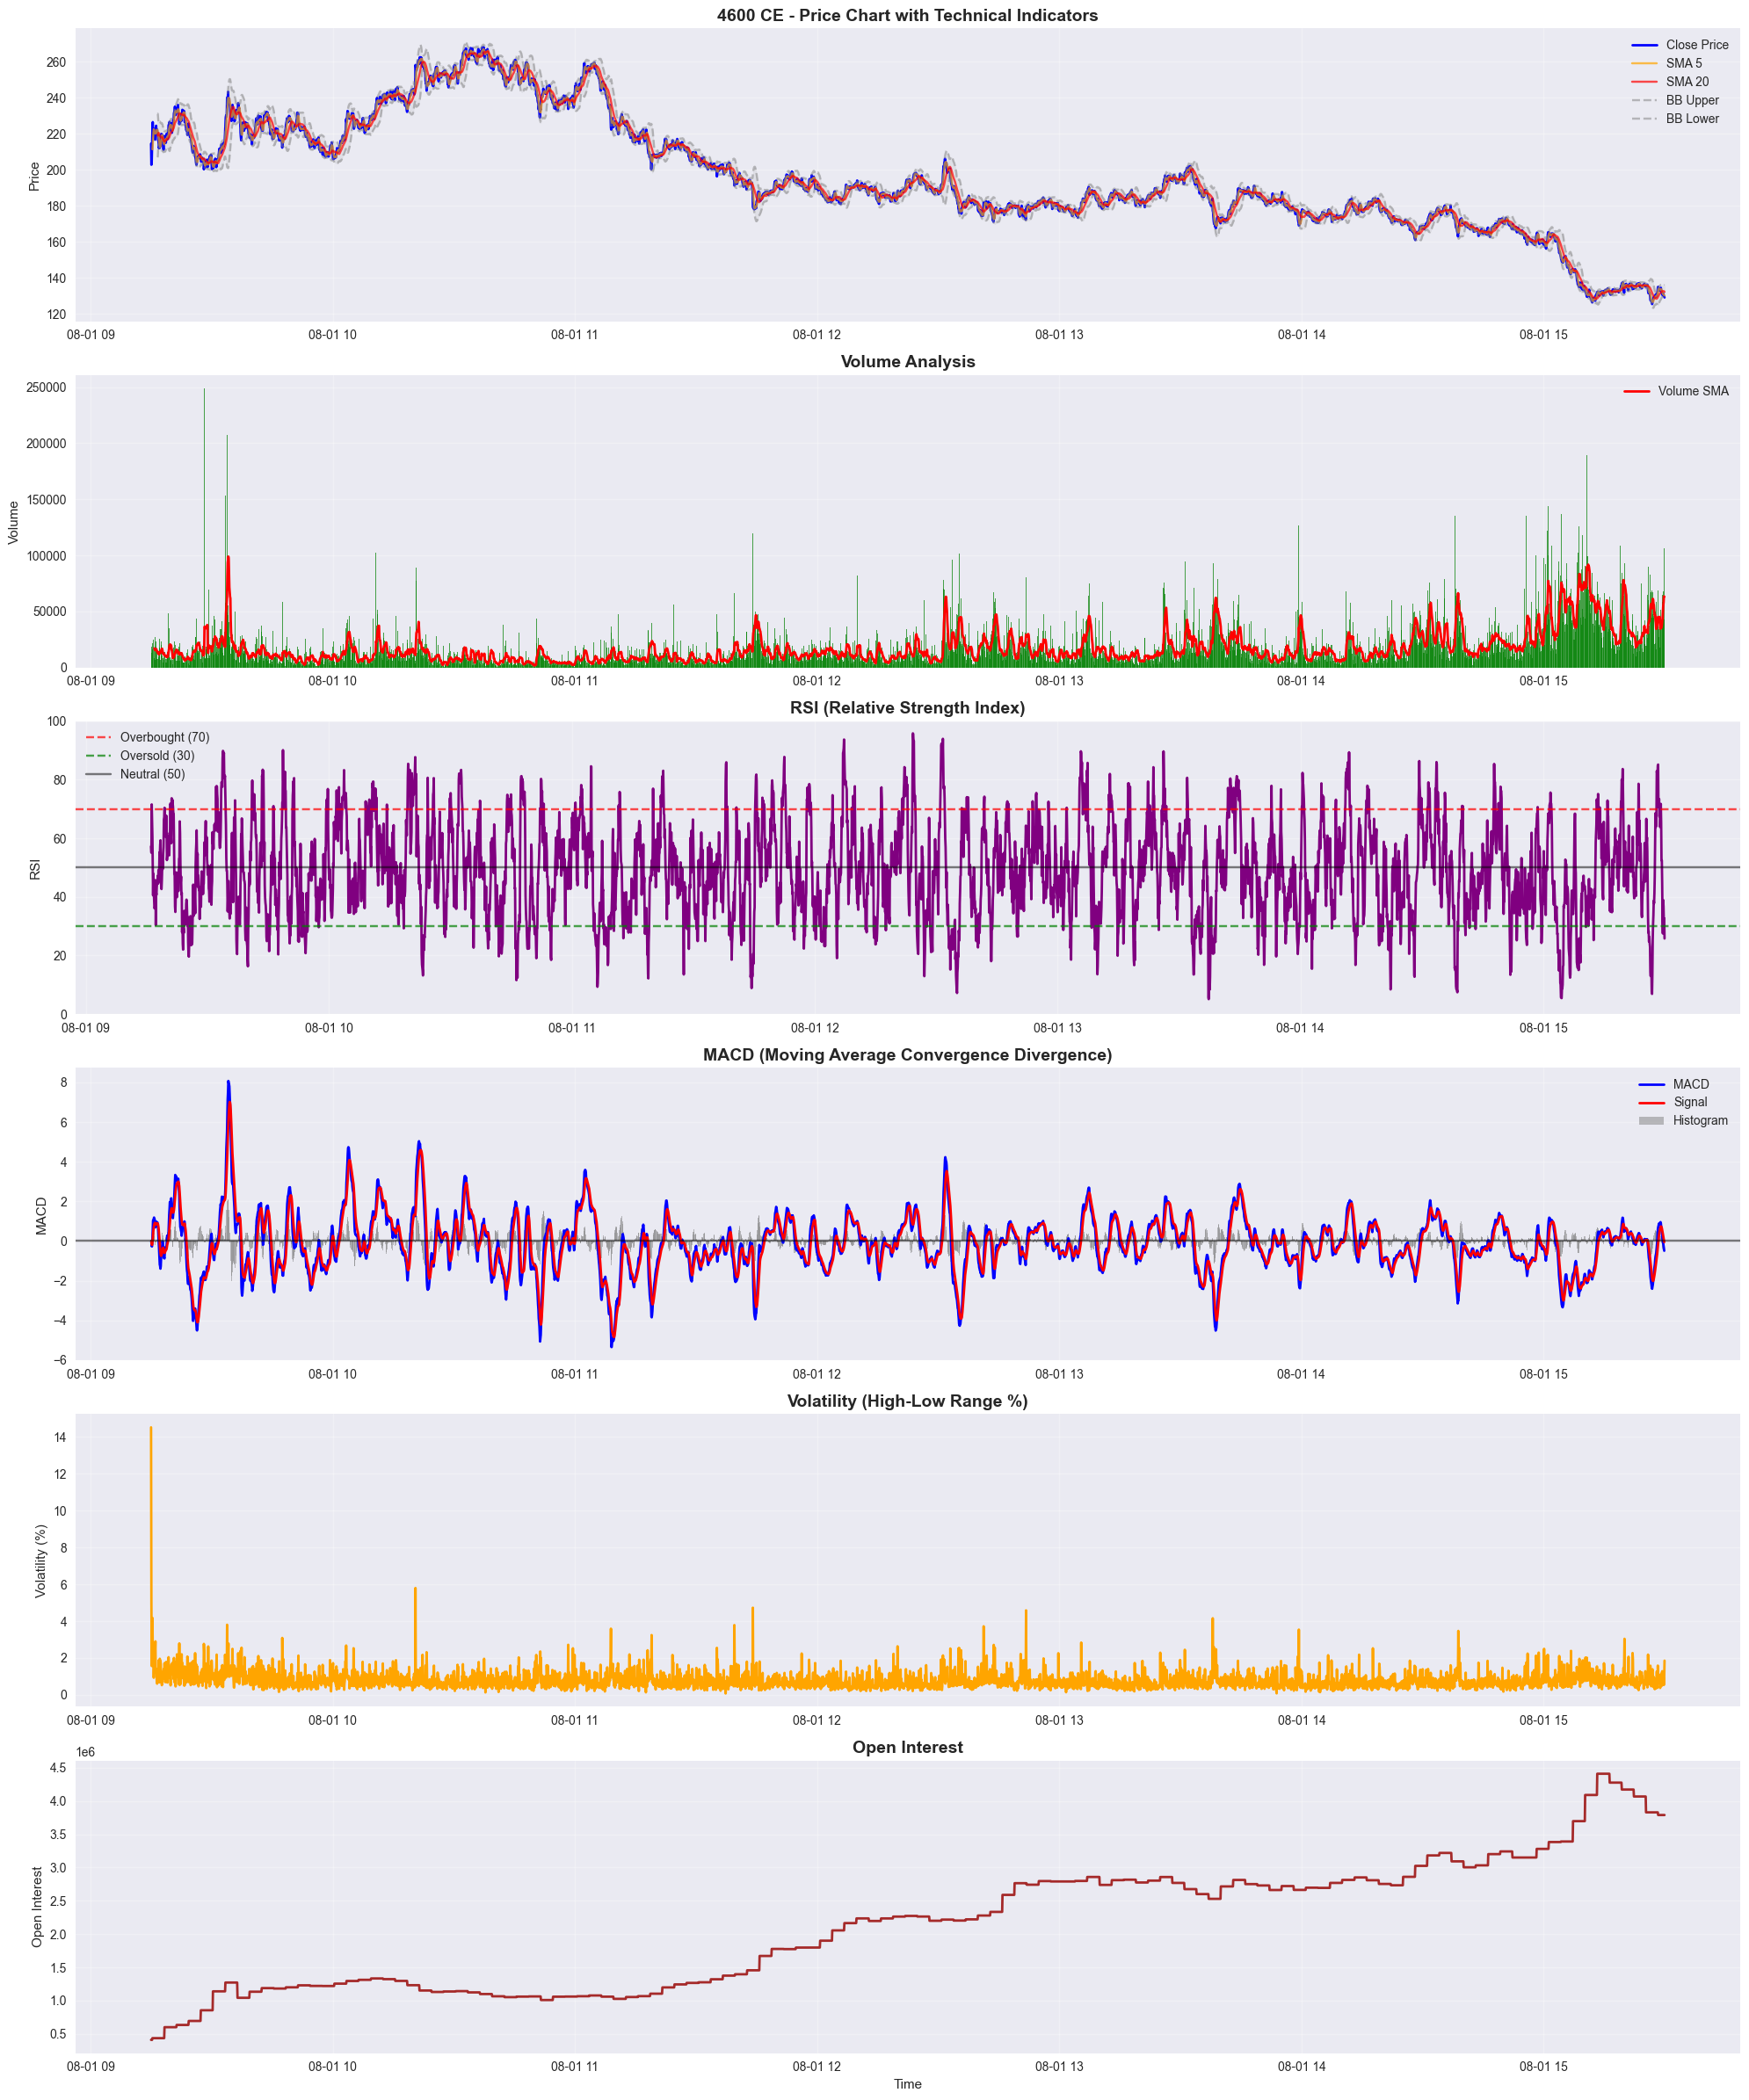

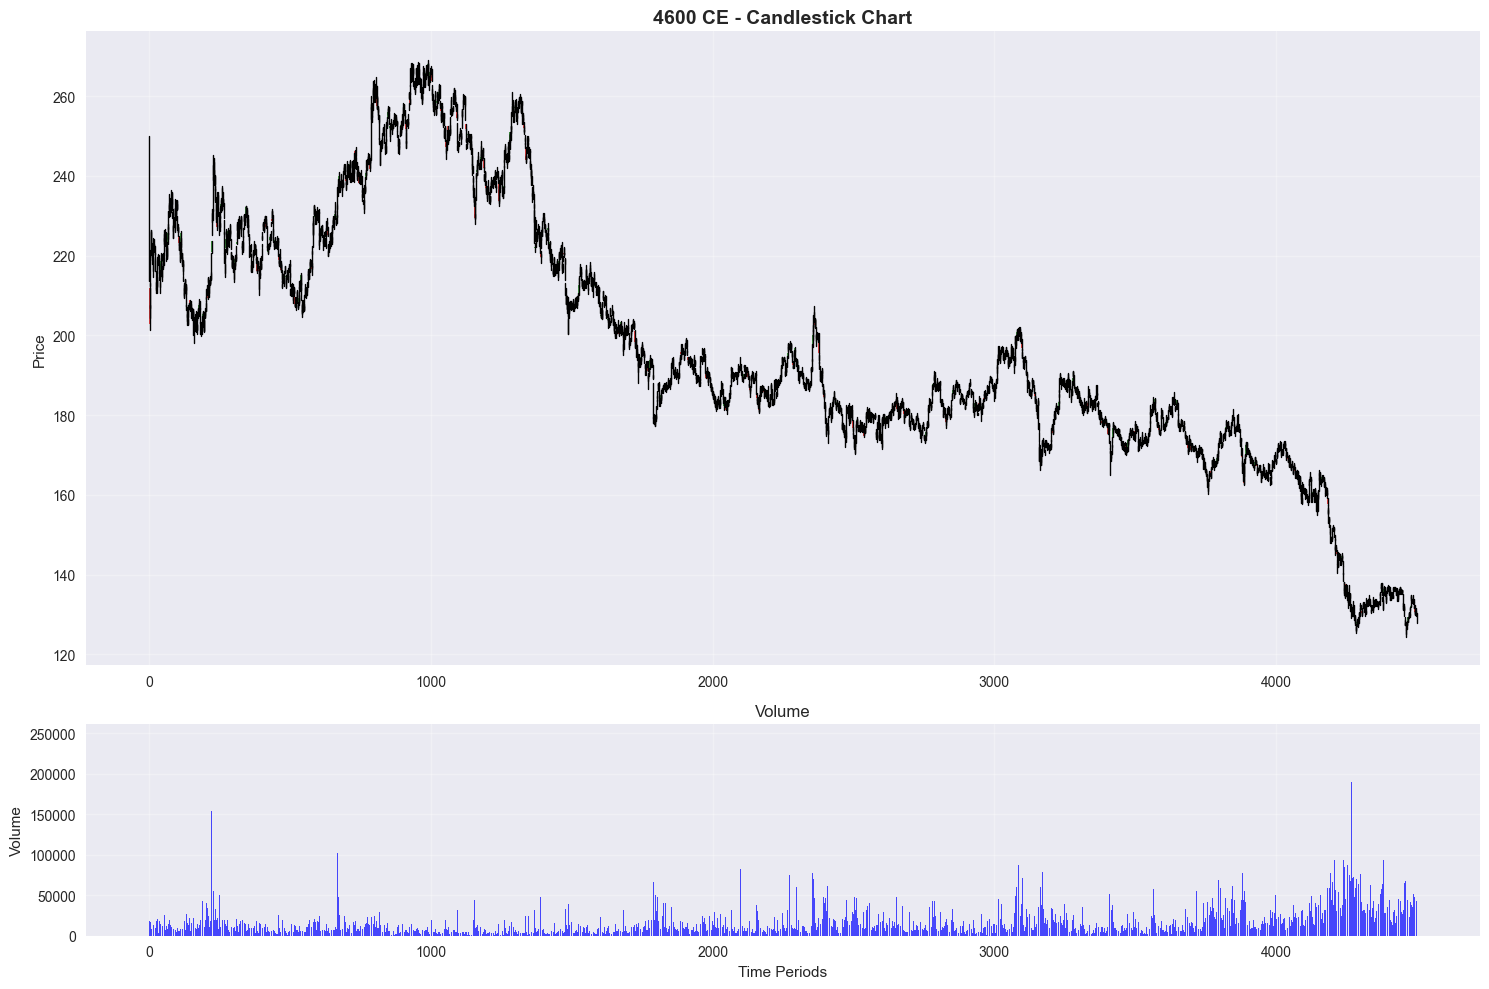

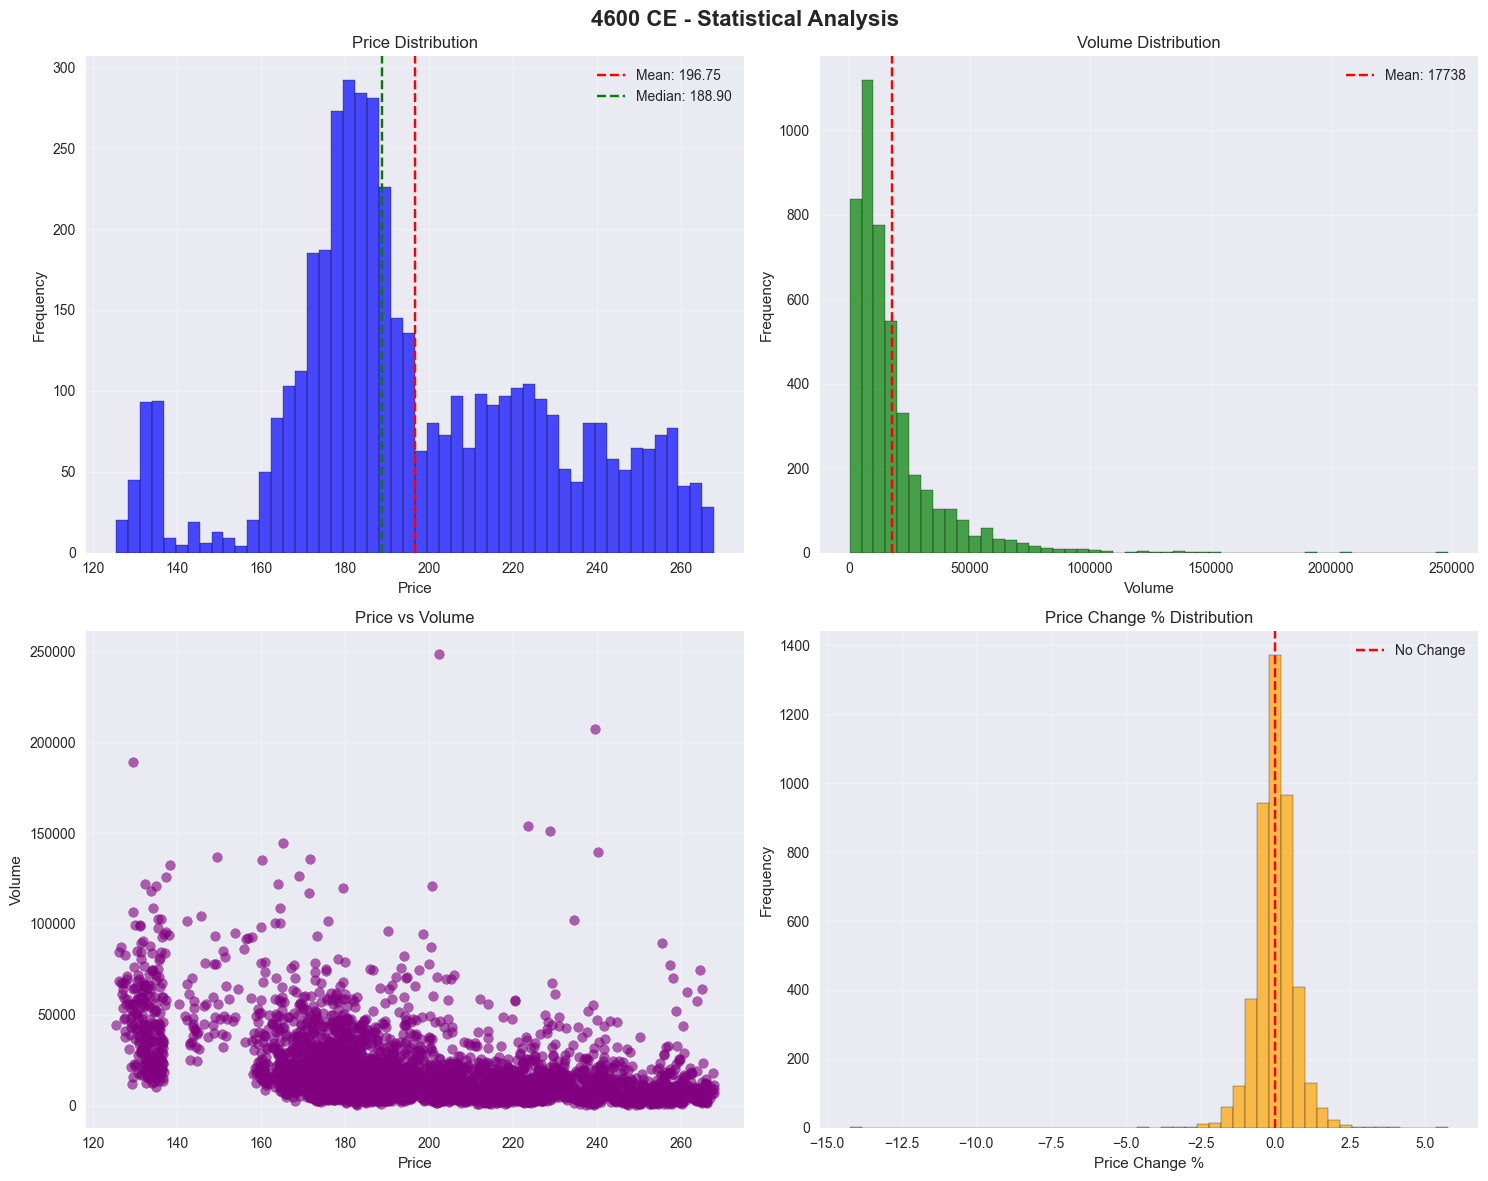

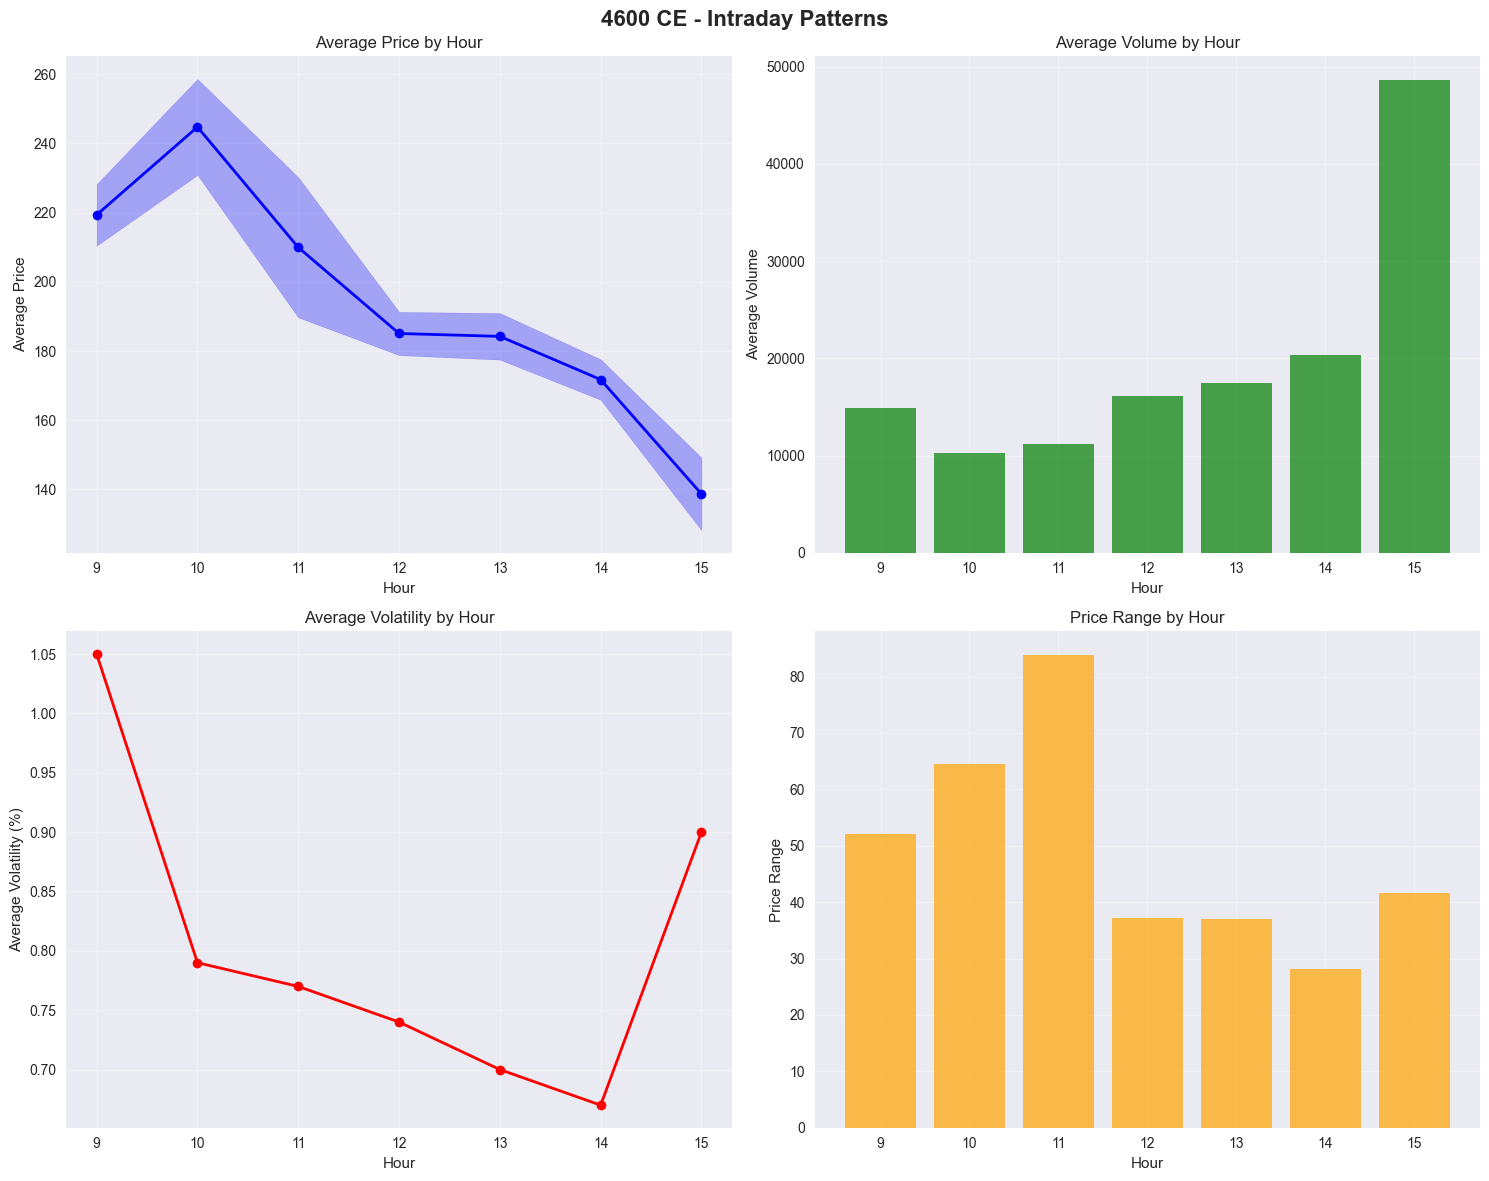


Hourly Statistics:
       close           volume volatility
        mean    std      mean       mean
hour                                    
9     219.36   8.87  14924.58       1.05
10    244.77  13.86  10274.79       0.79
11    209.97  20.24  11140.52       0.77
12    185.07   6.24  16115.73       0.74
13    184.24   6.72  17455.52       0.70
14    171.75   5.83  20373.85       0.67
15    138.69  10.48  48617.92       0.90


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

class SingleOptionAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.strike = None
        self.option_type = None
        
    def load_and_parse_file(self):
        """
        Load the CSV file and parse filename to extract strike and option type
        """
        print(f"Loading file: {self.file_path}")
        
        # Load the data
        self.data = pd.read_csv(self.file_path)
        
        # Parse filename to extract strike and option type
        filename = self.file_path.split('/')[-1]
        import re
        
        # Extract strike price and option type from filename
        match = re.search(r'nse_nifty\d+(\d{4})(ce|pe)_min\.csv', filename)
        if match:
            self.strike = int(match.group(1))
            self.option_type = match.group(2).upper()
            print(f"Strike: {self.strike}, Option Type: {self.option_type}")
        else:
            print("Could not parse strike and option type from filename")
        
        # Convert timestamp to datetime
        self.data['timestamp'] = pd.to_datetime(self.data['timestamp'])
        
        # Ensure numeric columns are numeric
        numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'oi']
        for col in numeric_cols:
            self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
        
        # Remove any rows with missing values
        self.data.dropna(inplace=True)
        
        # Remove rows with invalid prices
        self.data = self.data[
            (self.data['open'] > 0) & 
            (self.data['high'] > 0) & 
            (self.data['low'] > 0) & 
            (self.data['close'] > 0)
        ]
        
        # Calculate additional metrics
        self.calculate_metrics()
        
        print(f"Data loaded successfully. Shape: {self.data.shape}")
        return self.data
    
    def calculate_metrics(self):
        """
        Calculate additional technical metrics
        """
        # Basic price metrics
        self.data['price_change'] = self.data['close'] - self.data['open']
        self.data['price_change_pct'] = (self.data['price_change'] / self.data['open']) * 100
        self.data['high_low_range'] = self.data['high'] - self.data['low']
        self.data['volatility'] = self.data['high_low_range'] / self.data['open'] * 100
        
        # Moving averages
        self.data['sma_5'] = self.data['close'].rolling(window=5).mean()
        self.data['sma_10'] = self.data['close'].rolling(window=10).mean()
        self.data['sma_20'] = self.data['close'].rolling(window=20).mean()
        
        # RSI
        self.data['rsi'] = self.calculate_rsi(self.data['close'])
        
        # Bollinger Bands
        self.data['bb_upper'], self.data['bb_lower'], self.data['bb_middle'] = self.calculate_bollinger_bands(self.data['close'])
        
        # MACD
        self.data['macd'], self.data['macd_signal'], self.data['macd_histogram'] = self.calculate_macd(self.data['close'])
        
        # Volume metrics
        self.data['volume_sma'] = self.data['volume'].rolling(window=10).mean()
        self.data['volume_ratio'] = self.data['volume'] / self.data['volume_sma']
        
        # Price momentum
        self.data['momentum'] = self.data['close'] - self.data['close'].shift(5)
        
        # True Range and ATR
        self.data['tr'] = self.calculate_true_range(self.data['high'], self.data['low'], self.data['close'])
        self.data['atr'] = self.data['tr'].rolling(window=14).mean()
    
    def calculate_rsi(self, prices, period=14):
        """Calculate RSI"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def calculate_bollinger_bands(self, prices, period=20, std_dev=2):
        """Calculate Bollinger Bands"""
        sma = prices.rolling(window=period).mean()
        std = prices.rolling(window=period).std()
        upper_band = sma + (std * std_dev)
        lower_band = sma - (std * std_dev)
        return upper_band, lower_band, sma
    
    def calculate_macd(self, prices, fast=12, slow=26, signal=9):
        """Calculate MACD"""
        ema_fast = prices.ewm(span=fast).mean()
        ema_slow = prices.ewm(span=slow).mean()
        macd = ema_fast - ema_slow
        macd_signal = macd.ewm(span=signal).mean()
        macd_histogram = macd - macd_signal
        return macd, macd_signal, macd_histogram
    
    def calculate_true_range(self, high, low, close):
        """Calculate True Range"""
        prev_close = close.shift(1)
        tr1 = high - low
        tr2 = abs(high - prev_close)
        tr3 = abs(low - prev_close)
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        return tr
    
    def get_summary_stats(self):
        """
        Get summary statistics for the option
        """
        summary = {
            'Strike Price': self.strike,
            'Option Type': self.option_type,
            'Total Records': len(self.data),
            'Date Range': f"{self.data['timestamp'].min()} to {self.data['timestamp'].max()}",
            'Current Price': self.data['close'].iloc[-1],
            'Open Price': self.data['open'].iloc[0],
            'Total Price Change': self.data['close'].iloc[-1] - self.data['open'].iloc[0],
            'Total Price Change %': ((self.data['close'].iloc[-1] - self.data['open'].iloc[0]) / self.data['open'].iloc[0]) * 100,
            'Highest Price': self.data['high'].max(),
            'Lowest Price': self.data['low'].min(),
            'Average Price': self.data['close'].mean(),
            'Total Volume': self.data['volume'].sum(),
            'Average Volume': self.data['volume'].mean(),
            'Max Volume': self.data['volume'].max(),
            'Current OI': self.data['oi'].iloc[-1],
            'Average OI': self.data['oi'].mean(),
            'Max OI': self.data['oi'].max(),
            'Average Volatility': self.data['volatility'].mean(),
            'Max Volatility': self.data['volatility'].max()
        }
        
        return pd.Series(summary)
    
    def plot_comprehensive_analysis(self):
        """
        Create comprehensive visualization of the option data
        """
        if self.data is None:
            print("Please load data first using load_and_parse_file()")
            return
        
        # Set up the plotting style
        plt.style.use('seaborn-v0_8')
        fig = plt.figure(figsize=(20, 24))
        
        # 1. Price Chart with Moving Averages and Bollinger Bands
        ax1 = plt.subplot(6, 1, 1)
        plt.plot(self.data['timestamp'], self.data['close'], label='Close Price', linewidth=2, color='blue')
        plt.plot(self.data['timestamp'], self.data['sma_5'], label='SMA 5', alpha=0.7, color='orange')
        plt.plot(self.data['timestamp'], self.data['sma_20'], label='SMA 20', alpha=0.7, color='red')
        plt.plot(self.data['timestamp'], self.data['bb_upper'], label='BB Upper', alpha=0.5, color='gray', linestyle='--')
        plt.plot(self.data['timestamp'], self.data['bb_lower'], label='BB Lower', alpha=0.5, color='gray', linestyle='--')
        plt.fill_between(self.data['timestamp'], self.data['bb_upper'], self.data['bb_lower'], alpha=0.1, color='gray')
        plt.title(f'{self.strike} {self.option_type} - Price Chart with Technical Indicators', fontsize=14, fontweight='bold')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Volume Chart
        ax2 = plt.subplot(6, 1, 2)
        plt.bar(self.data['timestamp'], self.data['volume'], alpha=0.7, color='green', width=0.0001)
        plt.plot(self.data['timestamp'], self.data['volume_sma'], color='red', linewidth=2, label='Volume SMA')
        plt.title('Volume Analysis', fontsize=14, fontweight='bold')
        plt.ylabel('Volume')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. RSI
        ax3 = plt.subplot(6, 1, 3)
        plt.plot(self.data['timestamp'], self.data['rsi'], color='purple', linewidth=2)
        plt.axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought (70)')
        plt.axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold (30)')
        plt.axhline(y=50, color='black', linestyle='-', alpha=0.5, label='Neutral (50)')
        plt.title('RSI (Relative Strength Index)', fontsize=14, fontweight='bold')
        plt.ylabel('RSI')
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. MACD
        ax4 = plt.subplot(6, 1, 4)
        plt.plot(self.data['timestamp'], self.data['macd'], label='MACD', color='blue', linewidth=2)
        plt.plot(self.data['timestamp'], self.data['macd_signal'], label='Signal', color='red', linewidth=2)
        plt.bar(self.data['timestamp'], self.data['macd_histogram'], alpha=0.5, color='gray', label='Histogram', width=0.0001)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.title('MACD (Moving Average Convergence Divergence)', fontsize=14, fontweight='bold')
        plt.ylabel('MACD')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 5. Volatility
        ax5 = plt.subplot(6, 1, 5)
        plt.plot(self.data['timestamp'], self.data['volatility'], color='orange', linewidth=2)
        plt.title('Volatility (High-Low Range %)', fontsize=14, fontweight='bold')
        plt.ylabel('Volatility (%)')
        plt.grid(True, alpha=0.3)
        
        # 6. Open Interest
        ax6 = plt.subplot(6, 1, 6)
        plt.plot(self.data['timestamp'], self.data['oi'], color='brown', linewidth=2)
        plt.title('Open Interest', fontsize=14, fontweight='bold')
        plt.ylabel('Open Interest')
        plt.xlabel('Time')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_candlestick_chart(self, start_time=None, end_time=None):
        """
        Create a candlestick chart for the option
        """
        if self.data is None:
            print("Please load data first using load_and_parse_file()")
            return
        
        # Filter data by time range if specified
        if start_time and end_time:
            mask = (self.data['timestamp'] >= start_time) & (self.data['timestamp'] <= end_time)
            plot_data = self.data[mask]
        else:
            plot_data = self.data
        
        if len(plot_data) == 0:
            print("No data available for the specified time range")
            return
        
        # Create candlestick chart
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})
        
        # Candlestick chart
        for i, (idx, row) in enumerate(plot_data.iterrows()):
            color = 'green' if row['close'] >= row['open'] else 'red'
            
            # Body
            ax1.bar(i, row['close'] - row['open'], bottom=row['open'], 
                   color=color, alpha=0.7, width=0.8)
            
            # Wicks
            ax1.plot([i, i], [row['low'], row['high']], color='black', linewidth=1)
        
        ax1.set_title(f'{self.strike} {self.option_type} - Candlestick Chart', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Price')
        ax1.grid(True, alpha=0.3)
        
        # Volume chart
        ax2.bar(range(len(plot_data)), plot_data['volume'], alpha=0.7, color='blue')
        ax2.set_title('Volume', fontsize=12)
        ax2.set_ylabel('Volume')
        ax2.set_xlabel('Time Periods')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_price_distribution(self):
        """
        Plot price distribution and statistics
        """
        if self.data is None:
            print("Please load data first using load_and_parse_file()")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Price distribution histogram
        axes[0, 0].hist(self.data['close'], bins=50, alpha=0.7, color='blue', edgecolor='black')
        axes[0, 0].axvline(self.data['close'].mean(), color='red', linestyle='--', label=f'Mean: {self.data["close"].mean():.2f}')
        axes[0, 0].axvline(self.data['close'].median(), color='green', linestyle='--', label=f'Median: {self.data["close"].median():.2f}')
        axes[0, 0].set_title('Price Distribution')
        axes[0, 0].set_xlabel('Price')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Volume distribution
        axes[0, 1].hist(self.data['volume'], bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[0, 1].axvline(self.data['volume'].mean(), color='red', linestyle='--', label=f'Mean: {self.data["volume"].mean():.0f}')
        axes[0, 1].set_title('Volume Distribution')
        axes[0, 1].set_xlabel('Volume')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Price vs Volume scatter
        axes[1, 0].scatter(self.data['close'], self.data['volume'], alpha=0.6, color='purple')
        axes[1, 0].set_title('Price vs Volume')
        axes[1, 0].set_xlabel('Price')
        axes[1, 0].set_ylabel('Volume')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Price change distribution
        axes[1, 1].hist(self.data['price_change_pct'], bins=50, alpha=0.7, color='orange', edgecolor='black')
        axes[1, 1].axvline(0, color='red', linestyle='--', label='No Change')
        axes[1, 1].set_title('Price Change % Distribution')
        axes[1, 1].set_xlabel('Price Change %')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle(f'{self.strike} {self.option_type} - Statistical Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def plot_intraday_patterns(self):
        """
        Analyze and plot intraday patterns
        """
        if self.data is None:
            print("Please load data first using load_and_parse_file()")
            return
        
        # Extract time components
        self.data['hour'] = self.data['timestamp'].dt.hour
        self.data['minute'] = self.data['timestamp'].dt.minute
        self.data['time_of_day'] = self.data['timestamp'].dt.time
        
        # Group by time of day
        hourly_stats = self.data.groupby('hour').agg({
            'close': ['mean', 'std'],
            'volume': 'mean',
            'volatility': 'mean'
        }).round(2)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Average price by hour
        axes[0, 0].plot(hourly_stats.index, hourly_stats[('close', 'mean')], 'o-', color='blue', linewidth=2)
        axes[0, 0].fill_between(hourly_stats.index, 
                               hourly_stats[('close', 'mean')] - hourly_stats[('close', 'std')],
                               hourly_stats[('close', 'mean')] + hourly_stats[('close', 'std')],
                               alpha=0.3, color='blue')
        axes[0, 0].set_title('Average Price by Hour')
        axes[0, 0].set_xlabel('Hour')
        axes[0, 0].set_ylabel('Average Price')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Average volume by hour
        axes[0, 1].bar(hourly_stats.index, hourly_stats[('volume', 'mean')], alpha=0.7, color='green')
        axes[0, 1].set_title('Average Volume by Hour')
        axes[0, 1].set_xlabel('Hour')
        axes[0, 1].set_ylabel('Average Volume')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Average volatility by hour
        axes[1, 0].plot(hourly_stats.index, hourly_stats[('volatility', 'mean')], 'o-', color='red', linewidth=2)
        axes[1, 0].set_title('Average Volatility by Hour')
        axes[1, 0].set_xlabel('Hour')
        axes[1, 0].set_ylabel('Average Volatility (%)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Price range by hour
        hourly_range = self.data.groupby('hour').agg({
            'high': 'max',
            'low': 'min'
        })
        hourly_range['range'] = hourly_range['high'] - hourly_range['low']
        
        axes[1, 1].bar(hourly_range.index, hourly_range['range'], alpha=0.7, color='orange')
        axes[1, 1].set_title('Price Range by Hour')
        axes[1, 1].set_xlabel('Hour')
        axes[1, 1].set_ylabel('Price Range')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle(f'{self.strike} {self.option_type} - Intraday Patterns', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        return hourly_stats

# Usage example
if __name__ == "__main__":
    # Example usage - replace with your actual file path
    file_path = "Aug '25/Aug 07 Exp/01 Aug/5S/nse_nifty2580724600ce_min.csv"
    
    # Initialize analyzer
    analyzer = SingleOptionAnalyzer(file_path)
    
    # Load and parse the file
    data = analyzer.load_and_parse_file()
    
    # Get summary statistics
    summary = analyzer.get_summary_stats()
    print("\nSummary Statistics:")
    print(summary)
    
    # Create comprehensive analysis plots
    analyzer.plot_comprehensive_analysis()
    
    # Create candlestick chart
    analyzer.plot_candlestick_chart()
    
    # Create statistical analysis plots
    analyzer.plot_price_distribution()
    
    # Create intraday patterns analysis
    hourly_stats = analyzer.plot_intraday_patterns()
    print("\nHourly Statistics:")
    print(hourly_stats)

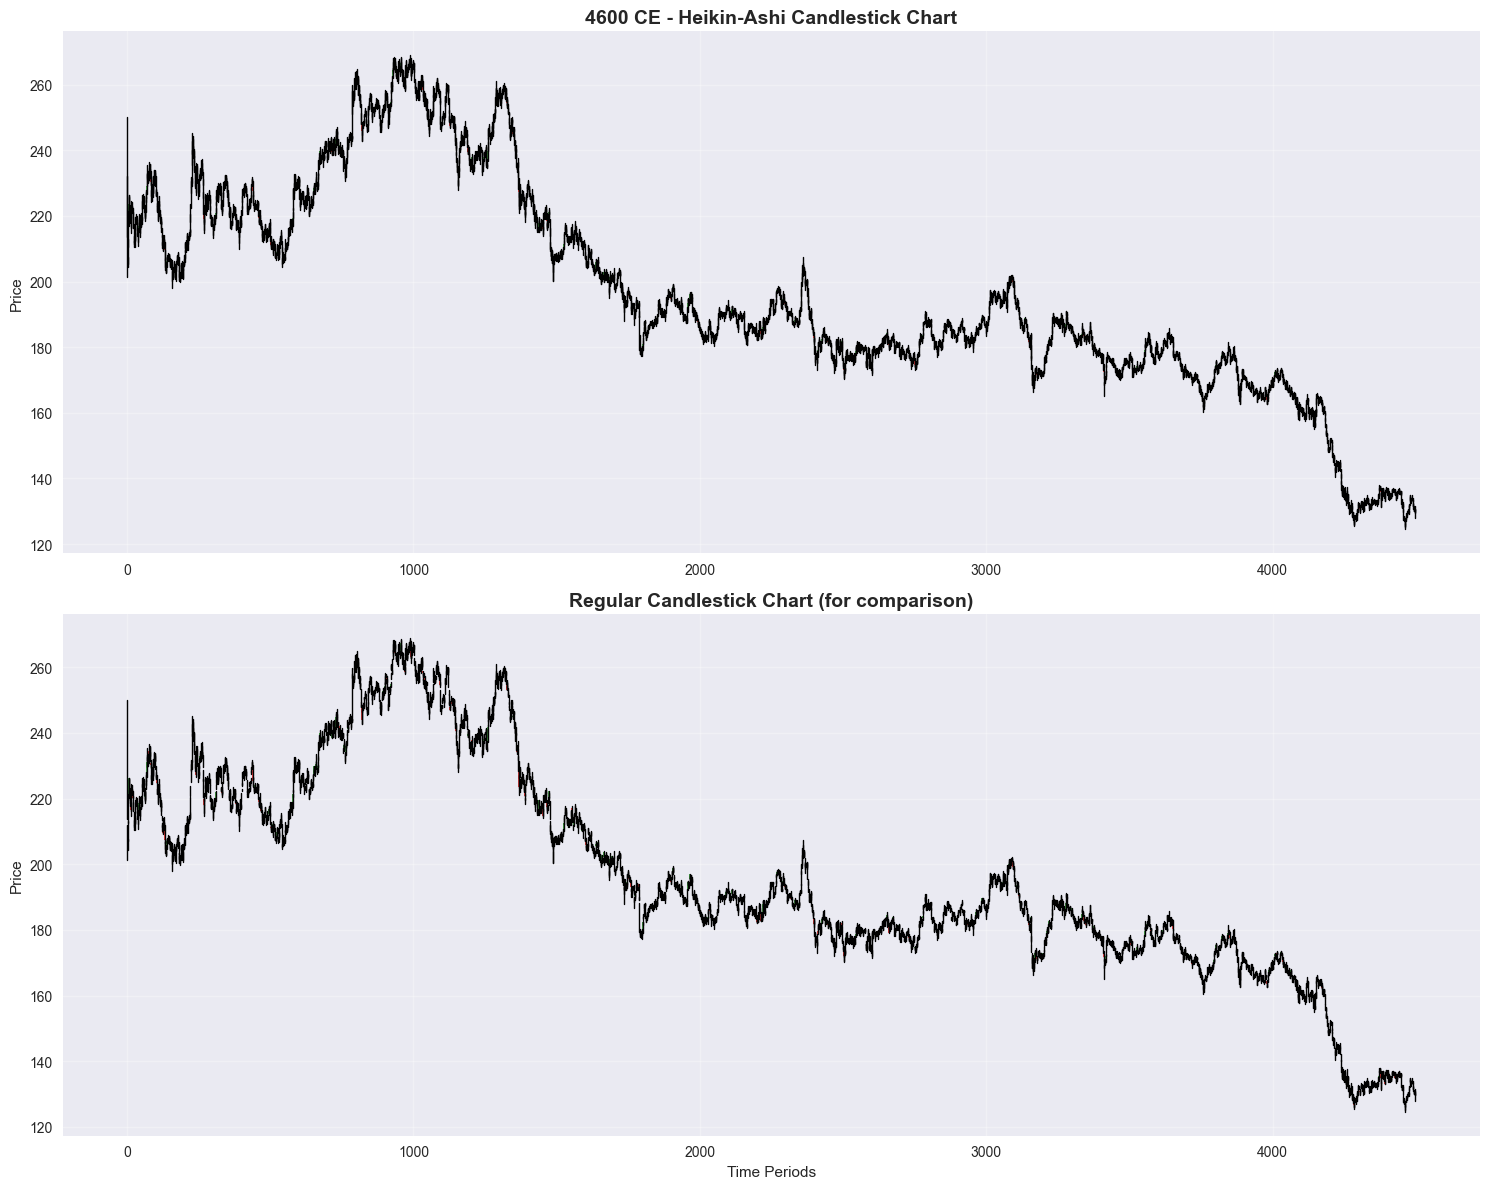

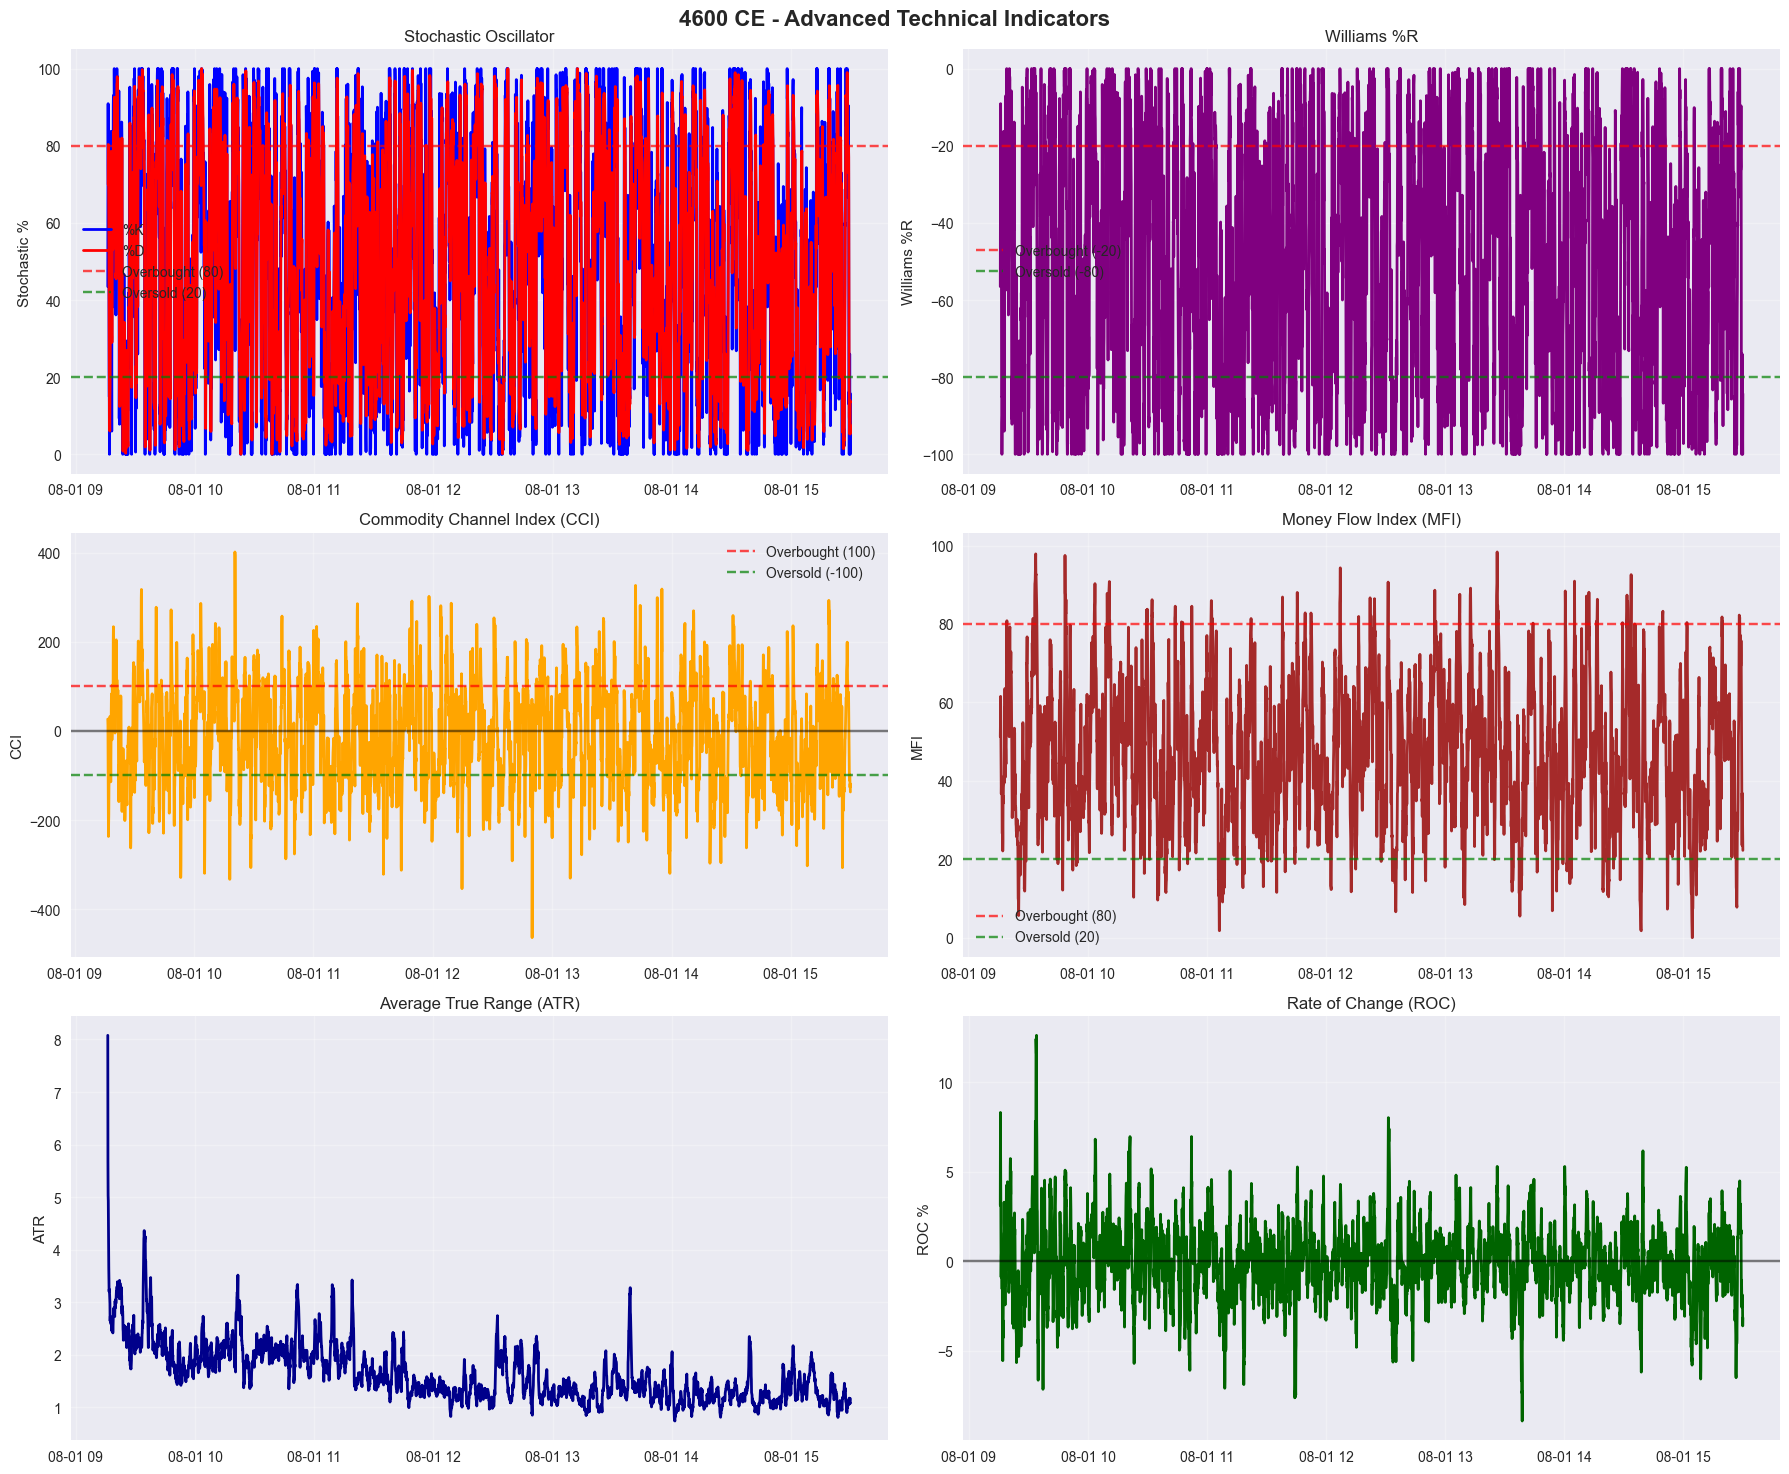

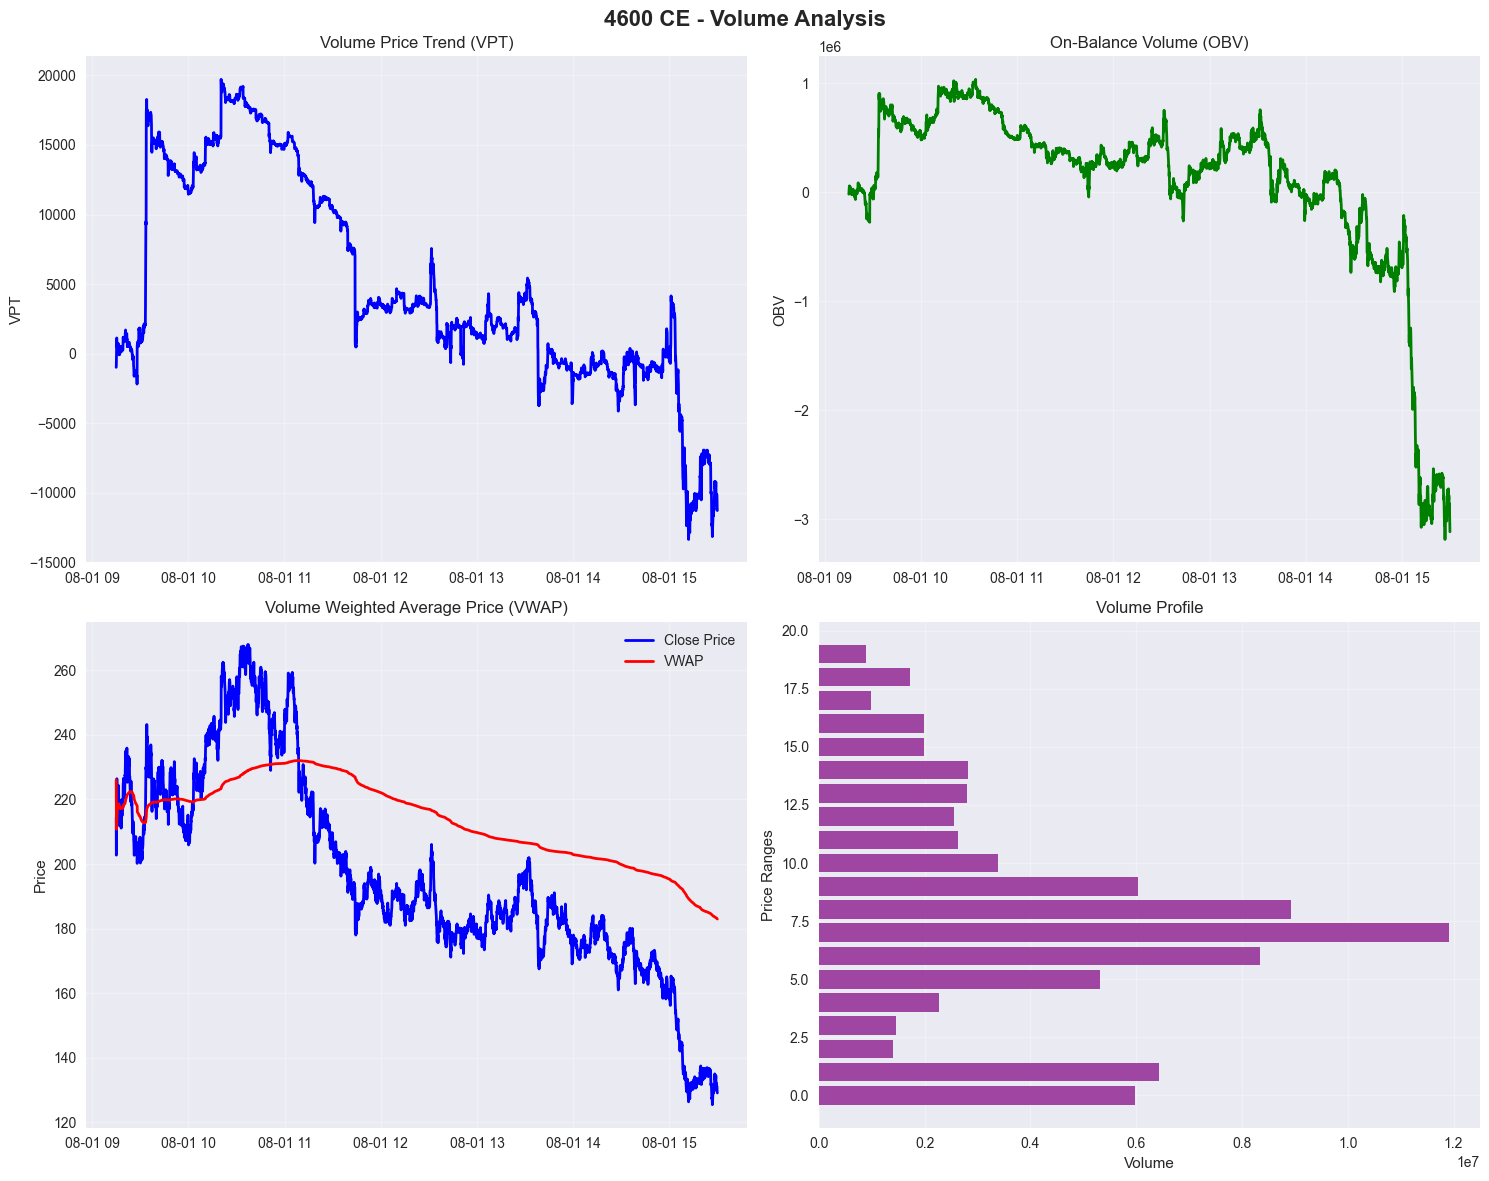

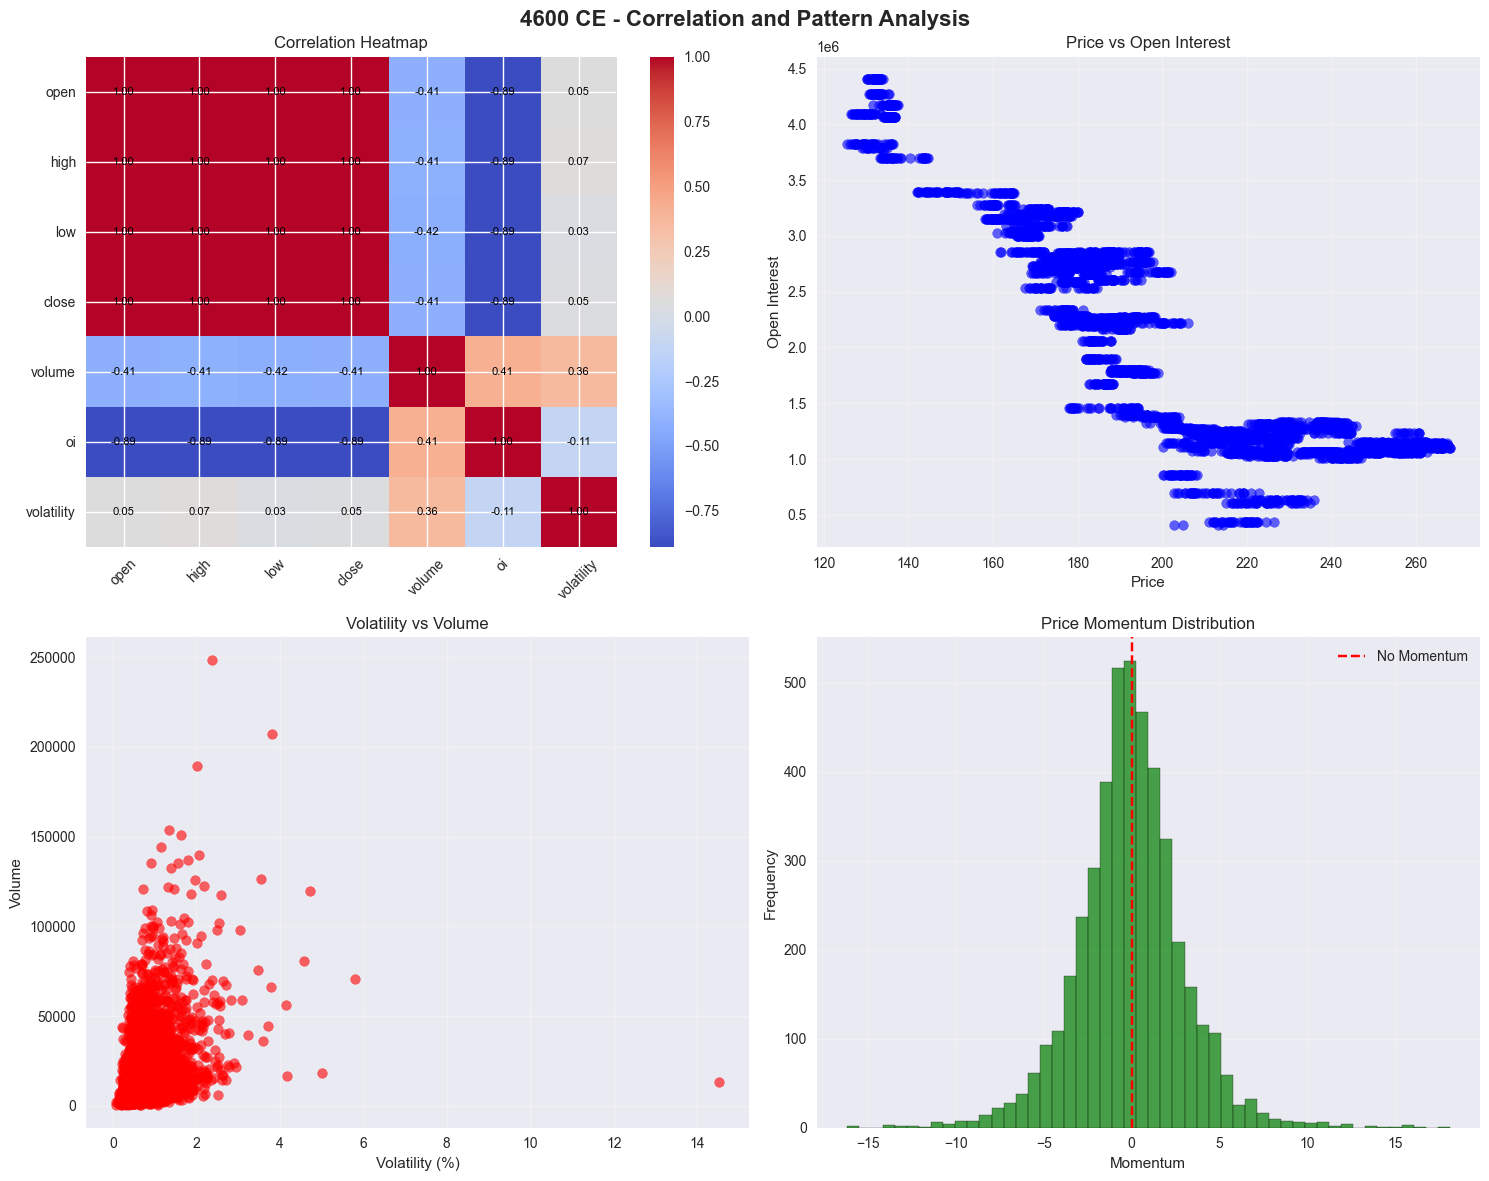


=== TRADING SIGNALS FOR 4600 CE ===
Total signals generated: 1863

Recent Trading Signals:
Time: 2025-08-01 15:28:20, Price: 135.00, Signals: RSI Overbought, BB Overbought, High Volume
Time: 2025-08-01 15:28:25, Price: 133.55, Signals: RSI Overbought
Time: 2025-08-01 15:28:30, Price: 133.30, Signals: RSI Overbought
Time: 2025-08-01 15:28:35, Price: 134.00, Signals: RSI Overbought
Time: 2025-08-01 15:29:00, Price: 134.45, Signals: RSI Overbought
Time: 2025-08-01 15:29:10, Price: 131.65, Signals: MACD Bearish Crossover, High Volume
Time: 2025-08-01 15:29:30, Price: 130.25, Signals: RSI Oversold
Time: 2025-08-01 15:29:35, Price: 131.30, Signals: High Volume
Time: 2025-08-01 15:29:50, Price: 129.60, Signals: High Volume
Time: 2025-08-01 15:29:55, Price: 129.10, Signals: RSI Oversold

=== ADDITIONAL INDICATORS SUMMARY FOR 4600 CE ===
Current VWAP: 182.96
Current OBV: -3,115,125
Current VPT: -11,292
Current CCI: -136.99
Current MFI: 22.26
Current Williams %R: -84.29


In [5]:
# Additional Charts and Analysis for Single Option
# This code assumes you have already run the previous code and have 'analyzer' object available

def create_additional_charts(analyzer):
    """
    Create additional specialized charts and analysis
    """
    if analyzer.data is None:
        print("Please run the previous code first to load data")
        return
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    
    # 1. HEIKIN-ASHI CANDLESTICK CHART
    def calculate_heikin_ashi(df):
        ha_df = df.copy()
        
        # Calculate Heikin-Ashi values
        ha_df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
        
        # Calculate HA_Open
        ha_df['HA_Open'] = ha_df['HA_Close'].shift(1)
        ha_df.loc[ha_df.index[0], 'HA_Open'] = (df.loc[df.index[0], 'open'] + df.loc[df.index[0], 'close']) / 2
        
        # Calculate HA_High and HA_Low
        ha_df['HA_High'] = ha_df[['high', 'HA_Open', 'HA_Close']].max(axis=1)
        ha_df['HA_Low'] = ha_df[['low', 'HA_Open', 'HA_Close']].min(axis=1)
        
        return ha_df
    
    ha_data = calculate_heikin_ashi(analyzer.data)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Heikin-Ashi candlestick
    for i, (idx, row) in enumerate(ha_data.iterrows()):
        color = 'green' if row['HA_Close'] >= row['HA_Open'] else 'red'
        
        # Body
        ax1.bar(i, row['HA_Close'] - row['HA_Open'], bottom=row['HA_Open'], 
               color=color, alpha=0.7, width=0.8)
        
        # Wicks
        ax1.plot([i, i], [row['HA_Low'], row['HA_High']], color='black', linewidth=1)
    
    ax1.set_title(f'{analyzer.strike} {analyzer.option_type} - Heikin-Ashi Candlestick Chart', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price')
    ax1.grid(True, alpha=0.3)
    
    # Regular candlestick for comparison
    for i, (idx, row) in enumerate(analyzer.data.iterrows()):
        color = 'green' if row['close'] >= row['open'] else 'red'
        
        # Body
        ax2.bar(i, row['close'] - row['open'], bottom=row['open'], 
               color=color, alpha=0.7, width=0.8)
        
        # Wicks
        ax2.plot([i, i], [row['low'], row['high']], color='black', linewidth=1)
    
    ax2.set_title('Regular Candlestick Chart (for comparison)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Price')
    ax2.set_xlabel('Time Periods')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. MOMENTUM AND OSCILLATOR INDICATORS
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    
    # Stochastic Oscillator
    def calculate_stochastic(df, k_period=14, d_period=3):
        low_min = df['low'].rolling(window=k_period).min()
        high_max = df['high'].rolling(window=k_period).max()
        k_percent = 100 * ((df['close'] - low_min) / (high_max - low_min))
        d_percent = k_percent.rolling(window=d_period).mean()
        return k_percent, d_percent
    
    k_percent, d_percent = calculate_stochastic(analyzer.data)
    
    axes[0, 0].plot(analyzer.data['timestamp'], k_percent, label='%K', color='blue', linewidth=2)
    axes[0, 0].plot(analyzer.data['timestamp'], d_percent, label='%D', color='red', linewidth=2)
    axes[0, 0].axhline(y=80, color='r', linestyle='--', alpha=0.7, label='Overbought (80)')
    axes[0, 0].axhline(y=20, color='g', linestyle='--', alpha=0.7, label='Oversold (20)')
    axes[0, 0].set_title('Stochastic Oscillator')
    axes[0, 0].set_ylabel('Stochastic %')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Williams %R
    def calculate_williams_r(df, period=14):
        high_max = df['high'].rolling(window=period).max()
        low_min = df['low'].rolling(window=period).min()
        williams_r = -100 * ((high_max - df['close']) / (high_max - low_min))
        return williams_r
    
    williams_r = calculate_williams_r(analyzer.data)
    
    axes[0, 1].plot(analyzer.data['timestamp'], williams_r, color='purple', linewidth=2)
    axes[0, 1].axhline(y=-20, color='r', linestyle='--', alpha=0.7, label='Overbought (-20)')
    axes[0, 1].axhline(y=-80, color='g', linestyle='--', alpha=0.7, label='Oversold (-80)')
    axes[0, 1].set_title('Williams %R')
    axes[0, 1].set_ylabel('Williams %R')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Commodity Channel Index (CCI)
    def calculate_cci(df, period=20):
        typical_price = (df['high'] + df['low'] + df['close']) / 3
        sma_tp = typical_price.rolling(window=period).mean()
        mad = typical_price.rolling(window=period).apply(lambda x: np.mean(np.abs(x - x.mean())))
        cci = (typical_price - sma_tp) / (0.015 * mad)
        return cci
    
    cci = calculate_cci(analyzer.data)
    
    axes[1, 0].plot(analyzer.data['timestamp'], cci, color='orange', linewidth=2)
    axes[1, 0].axhline(y=100, color='r', linestyle='--', alpha=0.7, label='Overbought (100)')
    axes[1, 0].axhline(y=-100, color='g', linestyle='--', alpha=0.7, label='Oversold (-100)')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1, 0].set_title('Commodity Channel Index (CCI)')
    axes[1, 0].set_ylabel('CCI')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Money Flow Index (MFI)
    def calculate_mfi(df, period=14):
        typical_price = (df['high'] + df['low'] + df['close']) / 3
        money_flow = typical_price * df['volume']
        
        positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
        negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0)
        
        positive_mf = positive_flow.rolling(window=period).sum()
        negative_mf = negative_flow.rolling(window=period).sum()
        
        mfi = 100 - (100 / (1 + (positive_mf / negative_mf)))
        return mfi
    
    mfi = calculate_mfi(analyzer.data)
    
    axes[1, 1].plot(analyzer.data['timestamp'], mfi, color='brown', linewidth=2)
    axes[1, 1].axhline(y=80, color='r', linestyle='--', alpha=0.7, label='Overbought (80)')
    axes[1, 1].axhline(y=20, color='g', linestyle='--', alpha=0.7, label='Oversold (20)')
    axes[1, 1].set_title('Money Flow Index (MFI)')
    axes[1, 1].set_ylabel('MFI')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Average True Range (ATR)
    axes[2, 0].plot(analyzer.data['timestamp'], analyzer.data['atr'], color='darkblue', linewidth=2)
    axes[2, 0].set_title('Average True Range (ATR)')
    axes[2, 0].set_ylabel('ATR')
    axes[2, 0].grid(True, alpha=0.3)
    
    # Price Rate of Change (ROC)
    def calculate_roc(df, period=10):
        roc = ((df['close'] - df['close'].shift(period)) / df['close'].shift(period)) * 100
        return roc
    
    roc = calculate_roc(analyzer.data)
    
    axes[2, 1].plot(analyzer.data['timestamp'], roc, color='darkgreen', linewidth=2)
    axes[2, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[2, 1].set_title('Rate of Change (ROC)')
    axes[2, 1].set_ylabel('ROC %')
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Advanced Technical Indicators', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 3. VOLUME ANALYSIS CHARTS
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Volume Price Trend (VPT)
    def calculate_vpt(df):
        vpt = (df['volume'] * ((df['close'] - df['close'].shift(1)) / df['close'].shift(1))).cumsum()
        return vpt
    
    vpt = calculate_vpt(analyzer.data)
    
    axes[0, 0].plot(analyzer.data['timestamp'], vpt, color='blue', linewidth=2)
    axes[0, 0].set_title('Volume Price Trend (VPT)')
    axes[0, 0].set_ylabel('VPT')
    axes[0, 0].grid(True, alpha=0.3)
    
    # On-Balance Volume (OBV)
    def calculate_obv(df):
        obv = (np.sign(df['close'].diff()) * df['volume']).cumsum()
        return obv
    
    obv = calculate_obv(analyzer.data)
    
    axes[0, 1].plot(analyzer.data['timestamp'], obv, color='green', linewidth=2)
    axes[0, 1].set_title('On-Balance Volume (OBV)')
    axes[0, 1].set_ylabel('OBV')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Volume Weighted Average Price (VWAP)
    def calculate_vwap(df):
        typical_price = (df['high'] + df['low'] + df['close']) / 3
        vwap = (typical_price * df['volume']).cumsum() / df['volume'].cumsum()
        return vwap
    
    vwap = calculate_vwap(analyzer.data)
    
    axes[1, 0].plot(analyzer.data['timestamp'], analyzer.data['close'], label='Close Price', color='blue', linewidth=2)
    axes[1, 0].plot(analyzer.data['timestamp'], vwap, label='VWAP', color='red', linewidth=2)
    axes[1, 0].set_title('Volume Weighted Average Price (VWAP)')
    axes[1, 0].set_ylabel('Price')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Volume Profile
    volume_profile = analyzer.data.groupby(pd.cut(analyzer.data['close'], bins=20))['volume'].sum()
    
    axes[1, 1].barh(range(len(volume_profile)), volume_profile.values, alpha=0.7, color='purple')
    axes[1, 1].set_title('Volume Profile')
    axes[1, 1].set_xlabel('Volume')
    axes[1, 1].set_ylabel('Price Ranges')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Volume Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 4. CORRELATION AND PATTERN ANALYSIS
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Correlation heatmap
    correlation_data = analyzer.data[['open', 'high', 'low', 'close', 'volume', 'oi', 'volatility']].corr()
    
    im = axes[0, 0].imshow(correlation_data, cmap='coolwarm', aspect='auto')
    axes[0, 0].set_xticks(range(len(correlation_data.columns)))
    axes[0, 0].set_yticks(range(len(correlation_data.columns)))
    axes[0, 0].set_xticklabels(correlation_data.columns, rotation=45)
    axes[0, 0].set_yticklabels(correlation_data.columns)
    axes[0, 0].set_title('Correlation Heatmap')
    
    # Add correlation values to the heatmap
    for i in range(len(correlation_data.columns)):
        for j in range(len(correlation_data.columns)):
            text = axes[0, 0].text(j, i, f'{correlation_data.iloc[i, j]:.2f}',
                                 ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=axes[0, 0])
    
    # Price vs OI scatter
    axes[0, 1].scatter(analyzer.data['close'], analyzer.data['oi'], alpha=0.6, color='blue')
    axes[0, 1].set_title('Price vs Open Interest')
    axes[0, 1].set_xlabel('Price')
    axes[0, 1].set_ylabel('Open Interest')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Volatility vs Volume scatter
    axes[1, 0].scatter(analyzer.data['volatility'], analyzer.data['volume'], alpha=0.6, color='red')
    axes[1, 0].set_title('Volatility vs Volume')
    axes[1, 0].set_xlabel('Volatility (%)')
    axes[1, 0].set_ylabel('Volume')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Price momentum distribution
    axes[1, 1].hist(analyzer.data['momentum'], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 1].axvline(0, color='red', linestyle='--', label='No Momentum')
    axes[1, 1].set_title('Price Momentum Distribution')
    axes[1, 1].set_xlabel('Momentum')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Correlation and Pattern Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 5. TRADING SIGNALS AND ALERTS
    def generate_trading_signals(df):
        signals = []
        
        # RSI signals
        rsi_oversold = df['rsi'] < 30
        rsi_overbought = df['rsi'] > 70
        
        # MACD signals
        macd_bullish = (df['macd'] > df['macd_signal']) & (df['macd'].shift(1) <= df['macd_signal'].shift(1))
        macd_bearish = (df['macd'] < df['macd_signal']) & (df['macd'].shift(1) >= df['macd_signal'].shift(1))
        
        # Bollinger Bands signals
        bb_oversold = df['close'] < df['bb_lower']
        bb_overbought = df['close'] > df['bb_upper']
        
        # Volume signals
        high_volume = df['volume'] > df['volume_sma'] * 1.5
        
        # Combine signals
        for i in range(len(df)):
            signal = {
                'timestamp': df.iloc[i]['timestamp'],
                'price': df.iloc[i]['close'],
                'signals': []
            }
            
            if rsi_oversold.iloc[i]:
                signal['signals'].append('RSI Oversold')
            if rsi_overbought.iloc[i]:
                signal['signals'].append('RSI Overbought')
            if macd_bullish.iloc[i]:
                signal['signals'].append('MACD Bullish Crossover')
            if macd_bearish.iloc[i]:
                signal['signals'].append('MACD Bearish Crossover')
            if bb_oversold.iloc[i]:
                signal['signals'].append('BB Oversold')
            if bb_overbought.iloc[i]:
                signal['signals'].append('BB Overbought')
            if high_volume.iloc[i]:
                signal['signals'].append('High Volume')
            
            if signal['signals']:
                signals.append(signal)
        
        return signals
    
    trading_signals = generate_trading_signals(analyzer.data)
    
    print(f"\n=== TRADING SIGNALS FOR {analyzer.strike} {analyzer.option_type} ===")
    print(f"Total signals generated: {len(trading_signals)}")
    
    if trading_signals:
        print("\nRecent Trading Signals:")
        for signal in trading_signals[-10:]:  # Show last 10 signals
            print(f"Time: {signal['timestamp']}, Price: {signal['price']:.2f}, Signals: {', '.join(signal['signals'])}")
    else:
        print("No trading signals generated in the current data.")
    
    return {
        'heikin_ashi_data': ha_data,
        'stochastic': (k_percent, d_percent),
        'williams_r': williams_r,
        'cci': cci,
        'mfi': mfi,
        'vpt': vpt,
        'obv': obv,
        'vwap': vwap,
        'trading_signals': trading_signals
    }

# Run the additional charts
additional_analysis = create_additional_charts(analyzer)

# Print summary of additional indicators
print(f"\n=== ADDITIONAL INDICATORS SUMMARY FOR {analyzer.strike} {analyzer.option_type} ===")
print(f"Current VWAP: {additional_analysis['vwap'].iloc[-1]:.2f}")
print(f"Current OBV: {additional_analysis['obv'].iloc[-1]:,.0f}")
print(f"Current VPT: {additional_analysis['vpt'].iloc[-1]:,.0f}")
print(f"Current CCI: {additional_analysis['cci'].iloc[-1]:.2f}")
print(f"Current MFI: {additional_analysis['mfi'].iloc[-1]:.2f}")
print(f"Current Williams %R: {additional_analysis['williams_r'].iloc[-1]:.2f}")

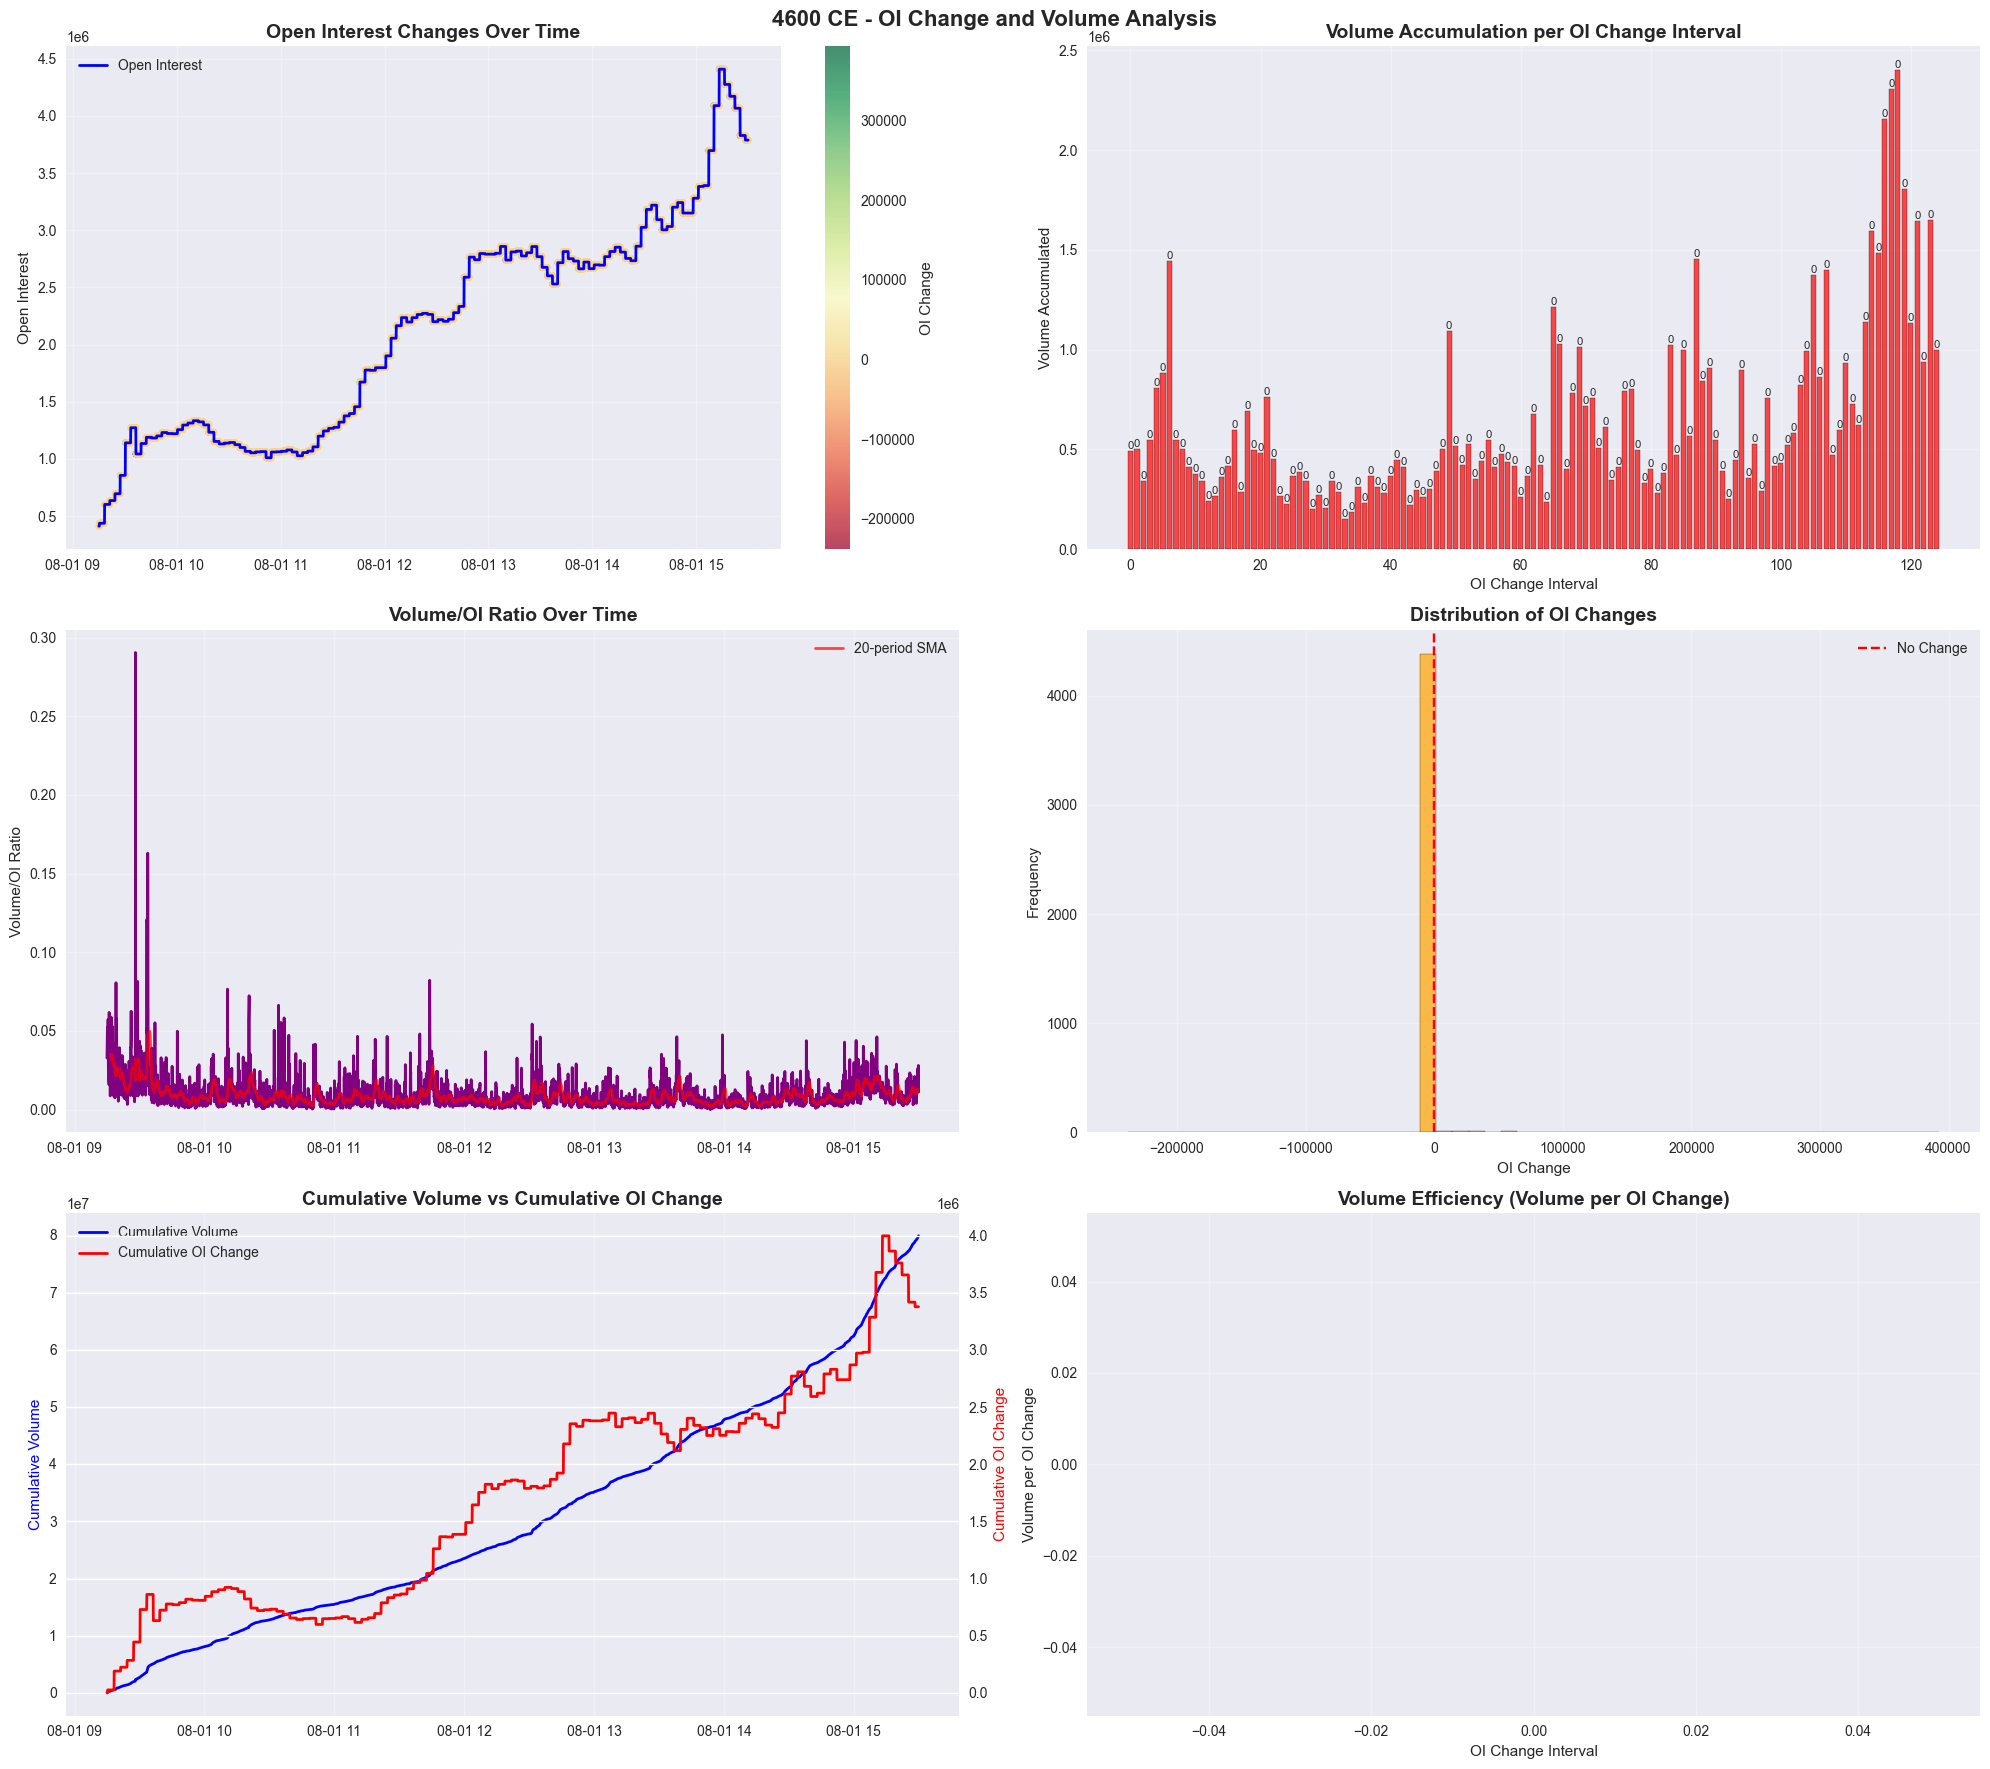


=== DETAILED OI CHANGE ANALYSIS FOR 4600 CE ===

Total OI Change Intervals: 125
Total OI Change: 0
Average OI Change per Interval: 0
Largest OI Increase: 0
Largest OI Decrease: 0

Volume Analysis:
Total Volume Accumulated: 79,747,650
Average Volume per Interval: 637,981
Average Volume/OI Ratio: 0.0089

Top 10 OI Change Intervals:
 interval  oi_change  volume_accumulated  duration  oi_change_pct
        1          0              494025        36            0.0
        2          0              503250        36            0.0
        3          0              340200        36            0.0
        4          0              544350        36            0.0
        5          0              804975        36            0.0
        6          0              880200        37            0.0
        7          0             1445775        36            0.0
        8          0              546750        36            0.0
        9          0              499125        36            0.0
       

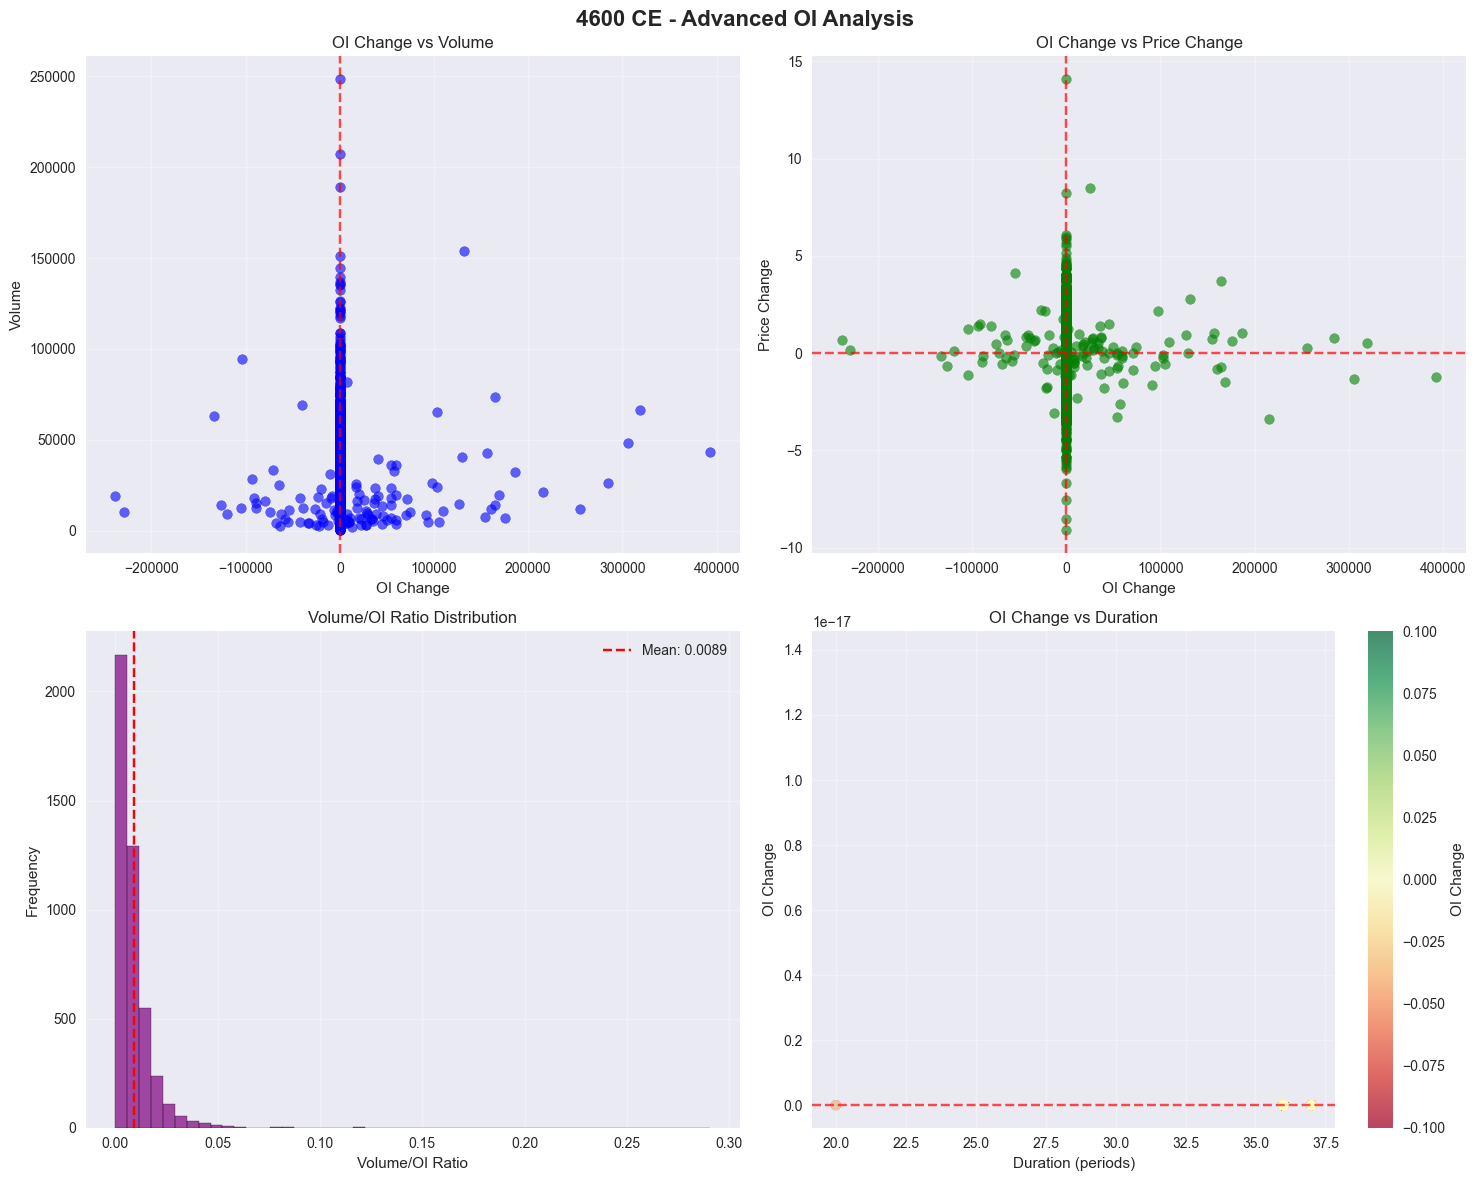


=== SUMMARY STATISTICS FOR 4600 CE ===
Average Volume per OI Change: inf
Volume Efficiency (median): nan
Most Active OI Change Interval: 119
Largest Volume Accumulation: 2,400,375
Average Duration per OI Change: 36.0 periods


In [6]:
# OI Change Analysis and Volume Accumulation
# This code analyzes OI changes and volume accumulation patterns

def analyze_oi_volume_patterns(analyzer):
    """
    Analyze OI changes and volume accumulation patterns
    """
    if analyzer.data is None:
        print("Please run the previous code first to load data")
        return
    
    # Create a copy of the data for analysis
    df = analyzer.data.copy()
    
    # Calculate OI changes
    df['oi_change'] = df['oi'].diff()
    df['oi_change_pct'] = (df['oi_change'] / df['oi'].shift(1)) * 100
    
    # Calculate cumulative volume for OI change intervals
    df['cumulative_volume'] = df['volume'].cumsum()
    
    # Identify OI change intervals
    df['oi_change_interval'] = 0
    current_interval = 0
    
    for i in range(1, len(df)):
        if df['oi_change'].iloc[i] != 0:  # OI changed
            current_interval += 1
        df.iloc[i, df.columns.get_loc('oi_change_interval')] = current_interval
    
    # Calculate volume accumulation for each OI change interval
    interval_stats = []
    
    for interval in df['oi_change_interval'].unique():
        if interval == 0:
            continue
            
        interval_data = df[df['oi_change_interval'] == interval]
        
        if len(interval_data) > 0:
            oi_start = interval_data['oi'].iloc[0]
            oi_end = interval_data['oi'].iloc[-1]
            oi_change = oi_end - oi_start
            volume_accumulated = interval_data['volume'].sum()
            duration = len(interval_data)
            avg_price = interval_data['close'].mean()
            
            interval_stats.append({
                'interval': interval,
                'oi_start': oi_start,
                'oi_end': oi_end,
                'oi_change': oi_change,
                'oi_change_pct': (oi_change / oi_start) * 100 if oi_start != 0 else 0,
                'volume_accumulated': volume_accumulated,
                'duration': duration,
                'avg_price': avg_price,
                'start_time': interval_data['timestamp'].iloc[0],
                'end_time': interval_data['timestamp'].iloc[-1]
            })
    
    interval_df = pd.DataFrame(interval_stats)
    
    # Calculate volume/OI ratio
    df['volume_oi_ratio'] = df['volume'] / df['oi']
    df['cumulative_volume_oi_ratio'] = df['volume_oi_ratio'].cumsum()
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    
    # 1. OI Change Over Time
    axes[0, 0].plot(df['timestamp'], df['oi'], color='blue', linewidth=2, label='Open Interest')
    axes[0, 0].scatter(df['timestamp'], df['oi'], c=df['oi_change'], cmap='RdYlGn', s=20, alpha=0.7)
    axes[0, 0].set_title('Open Interest Changes Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Open Interest')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add colorbar for OI changes
    scatter = axes[0, 0].scatter(df['timestamp'], df['oi'], c=df['oi_change'], cmap='RdYlGn', s=20, alpha=0.7)
    plt.colorbar(scatter, ax=axes[0, 0], label='OI Change')
    
    # 2. Volume Accumulation vs OI Changes
    if not interval_df.empty:
        colors = ['green' if x > 0 else 'red' for x in interval_df['oi_change']]
        axes[0, 1].bar(range(len(interval_df)), interval_df['volume_accumulated'], 
                      color=colors, alpha=0.7, edgecolor='black')
        axes[0, 1].set_title('Volume Accumulation per OI Change Interval', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('Volume Accumulated')
        axes[0, 1].set_xlabel('OI Change Interval')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Add OI change values on bars
        for i, (idx, row) in enumerate(interval_df.iterrows()):
            axes[0, 1].text(i, row['volume_accumulated'], f'{row["oi_change"]:,.0f}', 
                           ha='center', va='bottom', fontsize=8)
    
    # 3. Volume/OI Ratio Over Time
    axes[1, 0].plot(df['timestamp'], df['volume_oi_ratio'], color='purple', linewidth=2)
    axes[1, 0].set_title('Volume/OI Ratio Over Time', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Volume/OI Ratio')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add moving average of the ratio
    ratio_sma = df['volume_oi_ratio'].rolling(window=20).mean()
    axes[1, 0].plot(df['timestamp'], ratio_sma, color='red', linewidth=2, alpha=0.7, label='20-period SMA')
    axes[1, 0].legend()
    
    # 4. OI Change Distribution
    axes[1, 1].hist(df['oi_change'].dropna(), bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].axvline(0, color='red', linestyle='--', label='No Change')
    axes[1, 1].set_title('Distribution of OI Changes', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('OI Change')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 5. Cumulative Volume vs Cumulative OI Change
    df['cumulative_oi_change'] = df['oi_change'].cumsum()
    
    axes[2, 0].plot(df['timestamp'], df['cumulative_volume'], label='Cumulative Volume', color='blue', linewidth=2)
    ax2 = axes[2, 0].twinx()
    ax2.plot(df['timestamp'], df['cumulative_oi_change'], label='Cumulative OI Change', color='red', linewidth=2)
    
    axes[2, 0].set_title('Cumulative Volume vs Cumulative OI Change', fontsize=14, fontweight='bold')
    axes[2, 0].set_ylabel('Cumulative Volume', color='blue')
    ax2.set_ylabel('Cumulative OI Change', color='red')
    axes[2, 0].grid(True, alpha=0.3)
    
    # Combine legends
    lines1, labels1 = axes[2, 0].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axes[2, 0].legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # 6. Volume Efficiency (Volume per OI change)
    if not interval_df.empty:
        interval_df['volume_efficiency'] = interval_df['volume_accumulated'] / abs(interval_df['oi_change'])
        interval_df['volume_efficiency'] = interval_df['volume_efficiency'].replace([np.inf, -np.inf], np.nan)
        
        colors = ['green' if x > 0 else 'red' for x in interval_df['oi_change']]
        axes[2, 1].bar(range(len(interval_df)), interval_df['volume_efficiency'], 
                      color=colors, alpha=0.7, edgecolor='black')
        axes[2, 1].set_title('Volume Efficiency (Volume per OI Change)', fontsize=14, fontweight='bold')
        axes[2, 1].set_ylabel('Volume per OI Change')
        axes[2, 1].set_xlabel('OI Change Interval')
        axes[2, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - OI Change and Volume Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Create detailed OI change analysis table
    print(f"\n=== DETAILED OI CHANGE ANALYSIS FOR {analyzer.strike} {analyzer.option_type} ===")
    
    if not interval_df.empty:
        print(f"\nTotal OI Change Intervals: {len(interval_df)}")
        print(f"Total OI Change: {interval_df['oi_change'].sum():,.0f}")
        print(f"Average OI Change per Interval: {interval_df['oi_change'].mean():,.0f}")
        print(f"Largest OI Increase: {interval_df['oi_change'].max():,.0f}")
        print(f"Largest OI Decrease: {interval_df['oi_change'].min():,.0f}")
        
        print(f"\nVolume Analysis:")
        print(f"Total Volume Accumulated: {interval_df['volume_accumulated'].sum():,.0f}")
        print(f"Average Volume per Interval: {interval_df['volume_accumulated'].mean():,.0f}")
        print(f"Average Volume/OI Ratio: {df['volume_oi_ratio'].mean():.4f}")
        
        # Show top 10 OI change intervals
        print(f"\nTop 10 OI Change Intervals:")
        top_intervals = interval_df.nlargest(10, 'oi_change')[['interval', 'oi_change', 'volume_accumulated', 'duration', 'oi_change_pct']]
        print(top_intervals.to_string(index=False))
        
        # Show bottom 10 OI change intervals
        print(f"\nBottom 10 OI Change Intervals:")
        bottom_intervals = interval_df.nsmallest(10, 'oi_change')[['interval', 'oi_change', 'volume_accumulated', 'duration', 'oi_change_pct']]
        print(bottom_intervals.to_string(index=False))
    
    # Create additional specialized charts
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. OI Change vs Volume Scatter
    axes[0, 0].scatter(df['oi_change'], df['volume'], alpha=0.6, color='blue')
    axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_title('OI Change vs Volume')
    axes[0, 0].set_xlabel('OI Change')
    axes[0, 0].set_ylabel('Volume')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. OI Change vs Price Change
    axes[0, 1].scatter(df['oi_change'], df['price_change'], alpha=0.6, color='green')
    axes[0, 1].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].set_title('OI Change vs Price Change')
    axes[0, 1].set_xlabel('OI Change')
    axes[0, 1].set_ylabel('Price Change')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Volume/OI Ratio Distribution
    axes[1, 0].hist(df['volume_oi_ratio'].dropna(), bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 0].axvline(df['volume_oi_ratio'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {df["volume_oi_ratio"].mean():.4f}')
    axes[1, 0].set_title('Volume/OI Ratio Distribution')
    axes[1, 0].set_xlabel('Volume/OI Ratio')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. OI Change Duration Analysis
    if not interval_df.empty:
        axes[1, 1].scatter(interval_df['duration'], interval_df['oi_change'], 
                          c=interval_df['oi_change'], cmap='RdYlGn', alpha=0.7, s=50)
        axes[1, 1].axhline(0, color='red', linestyle='--', alpha=0.7)
        axes[1, 1].set_title('OI Change vs Duration')
        axes[1, 1].set_xlabel('Duration (periods)')
        axes[1, 1].set_ylabel('OI Change')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Add colorbar
        scatter = axes[1, 1].scatter(interval_df['duration'], interval_df['oi_change'], 
                                   c=interval_df['oi_change'], cmap='RdYlGn', alpha=0.7, s=50)
        plt.colorbar(scatter, ax=axes[1, 1], label='OI Change')
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Advanced OI Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return {
        'interval_analysis': interval_df,
        'oi_volume_data': df,
        'volume_oi_ratio': df['volume_oi_ratio'],
        'cumulative_volume': df['cumulative_volume'],
        'cumulative_oi_change': df['cumulative_oi_change']
    }

# Run the OI and Volume analysis
oi_volume_analysis = analyze_oi_volume_patterns(analyzer)

# Print summary statistics
print(f"\n=== SUMMARY STATISTICS FOR {analyzer.strike} {analyzer.option_type} ===")
if oi_volume_analysis['interval_analysis'] is not None and not oi_volume_analysis['interval_analysis'].empty:
    interval_df = oi_volume_analysis['interval_analysis']
    
    print(f"Average Volume per OI Change: {interval_df['volume_accumulated'].sum() / abs(interval_df['oi_change']).sum():.2f}")
    print(f"Volume Efficiency (median): {interval_df['volume_efficiency'].median():.2f}")
    print(f"Most Active OI Change Interval: {interval_df.loc[interval_df['volume_accumulated'].idxmax(), 'interval']}")
    print(f"Largest Volume Accumulation: {interval_df['volume_accumulated'].max():,.0f}")
    print(f"Average Duration per OI Change: {interval_df['duration'].mean():.1f} periods")